In [1]:
import os
import sys
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import importlib.resources as pkg_resources
import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

import sesame as ssm

In [2]:
raw_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'raw/')
output_path = os.path.join(os.path.dirname(os.getcwd()),'data', 'output/')
plot_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'plot/')
netcdf_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'netcdf/')
atlas_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'atlas/')

# Figure S1

In [29]:
merged_df = pd.read_csv(output_path + "crude_steel_merged.csv")
merged_df['year'] = pd.to_datetime(merged_df['year'], errors='coerce')
merged_df['year'] = merged_df['year'].dt.year
merged_df["steel_com"] = merged_df["steel_com"] * 1e-6
merged_df

Unnamed: 0 ISO3 country_trans  year  bgs_steel source_bgs    Country_x  \
0              0  AFG           NaN  1998        NaN        NaN  Afghanistan   
1              1  AFG           NaN  1999        NaN        NaN  Afghanistan   
2              2  AFG           NaN  2000        NaN        NaN  Afghanistan   
3              3  AFG           NaN  2001        NaN        NaN  Afghanistan   
4              4  AFG           NaN  2002        NaN        NaN  Afghanistan   
...          ...  ...           ...   ...        ...        ...          ...   
4634        4634  ZWE      Zimbabwe  2018     1322.0        BGS     Zimbabwe   
4635        4635  ZWE      Zimbabwe  2019     3583.0        BGS     Zimbabwe   
4636        4636  ZWE      Zimbabwe  2020     5196.0        BGS     Zimbabwe   
4637        4637  ZWE      Zimbabwe  2021     3921.0        BGS     Zimbabwe   
4638        4638  ZWE      Zimbabwe  2022     3900.0        BGS     Zimbabwe   

      usgs_steel source_usgs Country_y  wst_steel source_wst  steel_com source  
0            NaN        usgs       NaN        NaN        NaN        NaN    NaN  
1            NaN        usgs       NaN        NaN        NaN        NaN    NaN  
2            NaN        usgs       NaN        NaN        NaN        NaN    NaN  
3            NaN        usgs       NaN        NaN        NaN        NaN    NaN  
4            NaN        usgs       NaN        NaN        NaN        NaN    NaN  
...          ...         ...       ...        ...        ...        ...    ...  
4634         NaN        usgs  Zimbabwe        NaN        wst   0.001322    BGS  
4635         NaN        usgs  Zimbabwe        NaN        wst   0.003583    BGS  
4636         NaN        usgs  Zimbabwe        NaN        wst   0.005196    BGS  
4637         NaN        usgs  Zimbabwe        NaN        wst   0.003921    BGS  
4638         NaN        usgs       NaN        NaN        NaN   0.003900    BGS  

[4639 rows x 14 columns]

In [30]:
# Step 1: Assign % uncertainty based on your combination rules
def assign_uncertainty(row):
    if pd.isna(row['source']):
        return np.nan

    sources = [s.strip() for s in row['source'].split(',')]
    num_sources = len(sources)

    if num_sources == 1:
        return 0.15  # 15% uncertainty if only one source used
    elif num_sources == 2:
        return 0.10  # 10% uncertainty if two sources agree within 5%
    elif num_sources == 3:
        return 0.12  # 12% uncertainty if three sources used (fallback averaging)
    else:
        return np.nan

merged_df['steel_uncertainty'] = merged_df.apply(assign_uncertainty, axis=1)

# Step 2: Calculate lower and upper bounds
merged_df['steel_min'] = merged_df['steel_com'] * (1 - merged_df['steel_uncertainty'])
merged_df['steel_max'] = merged_df['steel_com'] * (1 + merged_df['steel_uncertainty'])

merged_df

Unnamed: 0 ISO3 country_trans  year  bgs_steel source_bgs    Country_x  \
0              0  AFG           NaN  1998        NaN        NaN  Afghanistan   
1              1  AFG           NaN  1999        NaN        NaN  Afghanistan   
2              2  AFG           NaN  2000        NaN        NaN  Afghanistan   
3              3  AFG           NaN  2001        NaN        NaN  Afghanistan   
4              4  AFG           NaN  2002        NaN        NaN  Afghanistan   
...          ...  ...           ...   ...        ...        ...          ...   
4634        4634  ZWE      Zimbabwe  2018     1322.0        BGS     Zimbabwe   
4635        4635  ZWE      Zimbabwe  2019     3583.0        BGS     Zimbabwe   
4636        4636  ZWE      Zimbabwe  2020     5196.0        BGS     Zimbabwe   
4637        4637  ZWE      Zimbabwe  2021     3921.0        BGS     Zimbabwe   
4638        4638  ZWE      Zimbabwe  2022     3900.0        BGS     Zimbabwe   

      usgs_steel source_usgs Country_y  wst_steel source_wst  steel_com  \
0            NaN        usgs       NaN        NaN        NaN        NaN   
1            NaN        usgs       NaN        NaN        NaN        NaN   
2            NaN        usgs       NaN        NaN        NaN        NaN   
3            NaN        usgs       NaN        NaN        NaN        NaN   
4            NaN        usgs       NaN        NaN        NaN        NaN   
...          ...         ...       ...        ...        ...        ...   
4634         NaN        usgs  Zimbabwe        NaN        wst   0.001322   
4635         NaN        usgs  Zimbabwe        NaN        wst   0.003583   
4636         NaN        usgs  Zimbabwe        NaN        wst   0.005196   
4637         NaN        usgs  Zimbabwe        NaN        wst   0.003921   
4638         NaN        usgs       NaN        NaN        NaN   0.003900   

     source  steel_uncertainty  steel_min  steel_max  
0       NaN                NaN        NaN        NaN  
1       NaN                NaN        NaN        NaN  
2       NaN                NaN        NaN        NaN  
3       NaN                NaN        NaN        NaN  
4       NaN                NaN        NaN        NaN  
...     ...                ...        ...        ...  
4634    BGS               0.15   0.001124   0.001520  
4635    BGS               0.15   0.003046   0.004120  
4636    BGS               0.15   0.004417   0.005975  
4637    BGS               0.15   0.003333   0.004509  
4638    BGS               0.15   0.003315   0.004485  

[4639 rows x 17 columns]

In [31]:
# Step 3: Aggregate by year to get global totals
annual_summary_steel = (
    merged_df.groupby(merged_df['year'])
    .agg(
        global_steel=('steel_com', 'sum'),
        global_min=('steel_min', 'sum'),
        global_max=('steel_max', 'sum')
    )
    .reset_index()
)
annual_summary_steel

year  global_steel   global_min   global_max
0   1970    593.579000   504.542150   682.615850
1   1971    580.368160   493.312936   667.423384
2   1972    630.658000   536.059300   725.256700
3   1973    698.332000   593.582200   803.081800
4   1974    706.522000   600.543700   812.500300
5   1975    647.627000   550.482950   744.771050
6   1976    679.112000   577.245200   780.978800
7   1977    668.907000   568.570950   769.243050
8   1978    708.882000   602.549700   815.214300
9   1979    739.749442   628.787026   850.711858
10  1980    713.154231   606.181096   820.127366
11  1981    705.196068   599.416658   810.975478
12  1982    641.874897   545.593662   738.156132
13  1983    661.605549   562.364717   760.846381
14  1984    707.486524   601.363545   813.609503
15  1985    716.415485   608.953162   823.877808
16  1986    711.658968   604.910123   818.407813
17  1987    732.721868   622.813588   842.630148
18  1988    776.359980   659.905983   892.813977
19  1989    781.212812   664.030890   898.394734
20  1990    768.908685   653.572382   884.244988
21  1991    734.438933   624.273093   844.604773
22  1992    717.912829   610.225905   825.599753
23  1993    725.429561   616.615127   834.243995
24  1994    725.092944   616.329002   833.856886
25  1995    751.373368   638.667363   864.079373
26  1996    750.059266   637.550376   862.568156
27  1997    796.783286   677.265793   916.300779
28  1998    776.221538   698.581735   853.861342
29  1999    789.842193   710.845768   868.838617
30  2000    849.145128   764.218179   934.072077
31  2001    851.067372   765.946187   936.188557
32  2002    904.076042   813.483568   994.668515
33  2003    974.374039   876.894354  1071.853724
34  2004   1073.684092   966.251509  1181.116675
35  2005   1145.404914  1030.788656  1260.021172
36  2006   1250.776537  1125.540086  1376.012988
37  2007   1348.797304  1213.847381  1483.747228
38  2008   1333.760575  1200.300192  1467.220959
39  2009   1234.661595  1111.109119  1358.214072
40  2010   1432.665171  1289.313676  1576.016666
41  2011   1523.227637  1370.416637  1676.038637
42  2012   1561.011202  1404.739948  1717.282456
43  2013   1651.281443  1485.950466  1816.612421
44  2014   1676.019911  1508.043933  1843.995889
45  2015   1625.824246  1462.982748  1788.665744
46  2016   1634.466651  1470.736963  1798.196338
47  2017   1738.855702  1564.623069  1913.088335
48  2018   1828.209187  1645.362602  2011.055772
49  2019   1877.864412  1690.033492  2065.695332
50  2020   1882.155938  1693.913657  2070.398219
51  2021   1958.377211  1762.435002  2154.319420
52  2022   1887.060255  1696.265120  2077.855391

In [32]:
merged_df = pd.read_csv(output_path + "iron_ore_merged.csv")
merged_df['year'] = pd.to_datetime(merged_df['year'], errors='coerce')
merged_df['year'] = merged_df['year'].dt.year
merged_df["iron_ore"] = merged_df["iron_ore"] * 1e-6
merged_df["iron_mfd"] = merged_df["iron_mfd"] * 1e-6
merged_df["iron_bgs"] = merged_df["iron_bgs"] * 1e-6
merged_df["iron_usgs"] = merged_df["iron_usgs"] * 1e-6
merged_df["iron_wst"] = merged_df["iron_wst"] * 1e-6
merged_df

Unnamed: 0 ISO3  year  iron_mfd source_mdf country_trans  iron_bgs  \
0               0  ABW  1970       NaN       UNEP           NaN       NaN   
1               1  ABW  1971       NaN       UNEP           NaN       NaN   
2               2  ABW  1972       NaN       UNEP           NaN       NaN   
3               3  ABW  1973       NaN       UNEP           NaN       NaN   
4               4  ABW  1974       NaN       UNEP           NaN       NaN   
...           ...  ...   ...       ...        ...           ...       ...   
10861       10861  ZWE  2017       NaN       UNEP           NaN       NaN   
10862       10862  ZWE  2018       NaN       UNEP           NaN       NaN   
10863       10863  ZWE  2019       NaN       UNEP           NaN       NaN   
10864       10864  ZWE  2020       NaN        NaN           NaN       NaN   
10865       10865  ZWE  2021       NaN        NaN           NaN       NaN   

      source_bgs  iron_usgs source_usgs   Country  iron_wst source_wst  \
0            NaN        NaN         NaN       NaN       NaN        NaN   
1            NaN        NaN         NaN       NaN       NaN        NaN   
2            NaN        NaN         NaN       NaN       NaN        NaN   
3            NaN        NaN         NaN       NaN       NaN        NaN   
4            NaN        NaN         NaN       NaN       NaN        NaN   
...          ...        ...         ...       ...       ...        ...   
10861        NaN        NaN        USGS  Zimbabwe       NaN        WST   
10862        NaN        NaN        USGS  Zimbabwe       NaN        WST   
10863        NaN        NaN        USGS  Zimbabwe       NaN        WST   
10864        NaN        NaN        USGS  Zimbabwe       NaN        WST   
10865        NaN        NaN        USGS  Zimbabwe       NaN        WST   

       iron_ore source  
0           NaN    NaN  
1           NaN    NaN  
2           NaN    NaN  
3           NaN    NaN  
4           NaN    NaN  
...         ...    ...  
10861       NaN    NaN  
10862       NaN    NaN  
10863       NaN    NaN  
10864       NaN    NaN  
10865       NaN    NaN  

[10866 rows x 15 columns]

In [33]:
# Uncertainty assumptions per source
source_uncertainty = {'UNEP': 0.10, 'BGS': 0.15, 'USGS': 0.20, 'WST': 0.30}
merged_df['iron_uncertainty'] = merged_df['source'].map(source_uncertainty)

# Step 2: Calculate lower and upper bounds
merged_df['iron_ore_min'] = merged_df['iron_ore'] * (1 - merged_df['iron_uncertainty'])
merged_df['iron_ore_max'] = merged_df['iron_ore'] * (1 + merged_df['iron_uncertainty'])

merged_df

Unnamed: 0 ISO3  year  iron_mfd source_mdf country_trans  iron_bgs  \
0               0  ABW  1970       NaN       UNEP           NaN       NaN   
1               1  ABW  1971       NaN       UNEP           NaN       NaN   
2               2  ABW  1972       NaN       UNEP           NaN       NaN   
3               3  ABW  1973       NaN       UNEP           NaN       NaN   
4               4  ABW  1974       NaN       UNEP           NaN       NaN   
...           ...  ...   ...       ...        ...           ...       ...   
10861       10861  ZWE  2017       NaN       UNEP           NaN       NaN   
10862       10862  ZWE  2018       NaN       UNEP           NaN       NaN   
10863       10863  ZWE  2019       NaN       UNEP           NaN       NaN   
10864       10864  ZWE  2020       NaN        NaN           NaN       NaN   
10865       10865  ZWE  2021       NaN        NaN           NaN       NaN   

      source_bgs  iron_usgs source_usgs   Country  iron_wst source_wst  \
0            NaN        NaN         NaN       NaN       NaN        NaN   
1            NaN        NaN         NaN       NaN       NaN        NaN   
2            NaN        NaN         NaN       NaN       NaN        NaN   
3            NaN        NaN         NaN       NaN       NaN        NaN   
4            NaN        NaN         NaN       NaN       NaN        NaN   
...          ...        ...         ...       ...       ...        ...   
10861        NaN        NaN        USGS  Zimbabwe       NaN        WST   
10862        NaN        NaN        USGS  Zimbabwe       NaN        WST   
10863        NaN        NaN        USGS  Zimbabwe       NaN        WST   
10864        NaN        NaN        USGS  Zimbabwe       NaN        WST   
10865        NaN        NaN        USGS  Zimbabwe       NaN        WST   

       iron_ore source  iron_uncertainty  iron_ore_min  iron_ore_max  
0           NaN    NaN               NaN           NaN           NaN  
1           NaN    NaN               NaN           NaN           NaN  
2           NaN    NaN               NaN           NaN           NaN  
3           NaN    NaN               NaN           NaN           NaN  
4           NaN    NaN               NaN           NaN           NaN  
...         ...    ...               ...           ...           ...  
10861       NaN    NaN               NaN           NaN           NaN  
10862       NaN    NaN               NaN           NaN           NaN  
10863       NaN    NaN               NaN           NaN           NaN  
10864       NaN    NaN               NaN           NaN           NaN  
10865       NaN    NaN               NaN           NaN           NaN  

[10866 rows x 18 columns]

In [34]:
# Step 3: Aggregate by year to get global totals
annual_summary_iron = (
    merged_df.groupby(merged_df['year'])
    .agg(
        global_iron=('iron_ore', 'sum'),
        global_min=('iron_ore_min', 'sum'),
        global_max=('iron_ore_max', 'sum')
    )
    .reset_index()
)
annual_summary_iron

year  global_iron   global_min   global_max
0   1970   767.693000   690.775000   844.611000
1   1971   782.301000   703.910700   860.691300
2   1972   775.065000   697.416800   852.713200
3   1973   841.367000   757.120450   925.613550
4   1974   893.959000   804.456600   983.461400
5   1975   897.557000   807.686350   987.427650
6   1976   905.471000   814.824100   996.117900
7   1977   852.206000   766.910200   937.501800
8   1978   849.247000   764.255500   934.238500
9   1979   910.739108   819.637721  1001.840495
10  1980   898.229439   808.403945   988.054933
11  1981   857.223082   771.498724   942.947440
12  1982   816.359731   734.721708   897.997754
13  1983   781.019479   702.915531   859.123427
14  1984   882.716212   794.442790   970.989633
15  1985   923.554933   831.199439  1015.910426
16  1986   938.154873   844.339385  1031.970360
17  1987   962.196343   865.976709  1058.415978
18  1988   981.333313   883.199981  1079.466644
19  1989  1000.648037   900.583234  1100.712841
20  1990   989.586670   890.628003  1088.545337
21  1991   968.108060   871.297254  1064.918866
22  1992   945.584639   851.023228  1040.146050
23  1993   953.764288   858.385575  1049.143002
24  1994  1010.488055   909.437783  1111.538326
25  1995  1060.392441   954.352171  1166.432711
26  1996  1035.253546   931.727182  1138.779911
27  1997  1077.013830   969.311336  1184.716325
28  1998  1065.247094   958.721378  1171.772809
29  1999  1033.629531   930.201406  1137.057655
30  2000  1102.285576   992.051000  1212.520153
31  2001  1064.828248   958.339799  1171.316696
32  2002  1131.775610  1018.596419  1244.954801
33  2003  1245.848254  1121.262429  1370.434080
34  2004  1384.796256  1246.315630  1523.276882
35  2005  1577.228394  1419.504555  1734.952234
36  2006  1842.409288  1658.025759  2026.792817
37  2007  2060.091947  1853.758353  2266.425542
38  2008  2239.818405  2015.786565  2463.850246
39  2009  2286.872821  2058.093339  2515.652304
40  2010  2641.745201  2377.088481  2906.401921
41  2011  3022.871166  2720.036849  3325.705482
42  2012  2981.969551  2683.185196  3280.753906
43  2013  3193.778641  2873.544777  3514.012506
44  2014  3466.832412  3119.281471  3814.383353
45  2015  3366.633524  3029.706372  3703.560677
46  2016  3326.664920  2993.706728  3659.623112
47  2017  3368.692342  3031.306908  3706.077776
48  2018  2959.032101  2662.689191  3255.375012
49  2019  3018.958736  2716.481354  3321.436117
50  2020  2473.025419  2100.400556  2845.650282
51  2021  2586.459742  2197.095131  2975.824353
52  2022  2504.339437  2128.688521  2879.990353

In [35]:
df = pd.read_csv(raw_path + "MISO2_by_enduse.xlsx.csv")
df = df[df["material"] == "iron_steel"]
df = df[df["name"] == "F_9_10_GAS_enduse"]

# Select the columns from 'region', 'material', and 'sector' + columns from 2000 to 2016
selected_columns = ['region'] + [str(year) for year in range(1970, 2017)]
df = df[selected_columns]
df_end = df.melt(id_vars=["region"], var_name='year', value_name='GAS')
annual_summary_gas = df_end.groupby(df_end['year'])["GAS"].sum().reset_index()
annual_summary_gas["GAS"] = annual_summary_gas["GAS"] * 1e-3
annual_summary_gas['global_min'] = annual_summary_gas['GAS'] * (1 - 0.10)
annual_summary_gas['global_max'] = annual_summary_gas['GAS'] * (1 + 0.10)
annual_summary_gas

year          GAS   global_min   global_max
0   1970   529.375522   476.437970   582.313075
1   1971   510.297015   459.267314   561.326717
2   1972   543.377670   489.039903   597.715436
3   1973   598.340503   538.506453   658.174553
4   1974   593.825941   534.443347   653.208535
5   1975   544.961534   490.465381   599.457688
6   1976   569.991644   512.992480   626.990808
7   1977   565.729141   509.156227   622.302055
8   1978   597.804371   538.023934   657.584808
9   1979   621.848612   559.663751   684.033473
10  1980   594.246403   534.821763   653.671043
11  1981   583.896373   525.506736   642.286010
12  1982   530.660232   477.594209   583.726255
13  1983   545.658073   491.092266   600.223881
14  1984   582.856590   524.570931   641.142249
15  1985   606.615007   545.953507   667.276508
16  1986   599.429801   539.486821   659.372781
17  1987   603.684828   543.316345   664.053311
18  1988   636.057283   572.451555   699.663012
19  1989   639.136832   575.223149   703.050516
20  1990   631.651875   568.486688   694.817063
21  1991   600.973499   540.876149   661.070849
22  1992   588.277950   529.450155   647.105745
23  1993   598.714176   538.842758   658.585594
24  1994   614.679109   553.211198   676.147020
25  1995   626.766149   564.089534   689.442763
26  1996   648.163811   583.347430   712.980192
27  1997   672.569652   605.312687   739.826617
28  1998   652.166558   586.949902   717.383214
29  1999   661.207178   595.086460   727.327896
30  2000   690.949214   621.854292   760.044135
31  2001   694.366796   624.930116   763.803476
32  2002   734.807231   661.326508   808.287954
33  2003   790.783759   711.705383   869.862135
34  2004   860.102304   774.092074   946.112534
35  2005   937.322267   843.590041  1031.054494
36  2006  1021.855301   919.669771  1124.040831
37  2007  1100.814943   990.733448  1210.896437
38  2008  1097.198772   987.478895  1206.918649
39  2009  1016.897847   915.208062  1118.587631
40  2010  1165.543538  1048.989184  1282.097892
41  2011  1242.082720  1117.874448  1366.290992
42  2012  1259.205526  1133.284973  1385.126078
43  2013  1327.907291  1195.116562  1460.698021
44  2014  1344.011350  1209.610215  1478.412485
45  2015  1292.708337  1163.437504  1421.979171
46  2016  1328.675581  1195.808023  1461.543139

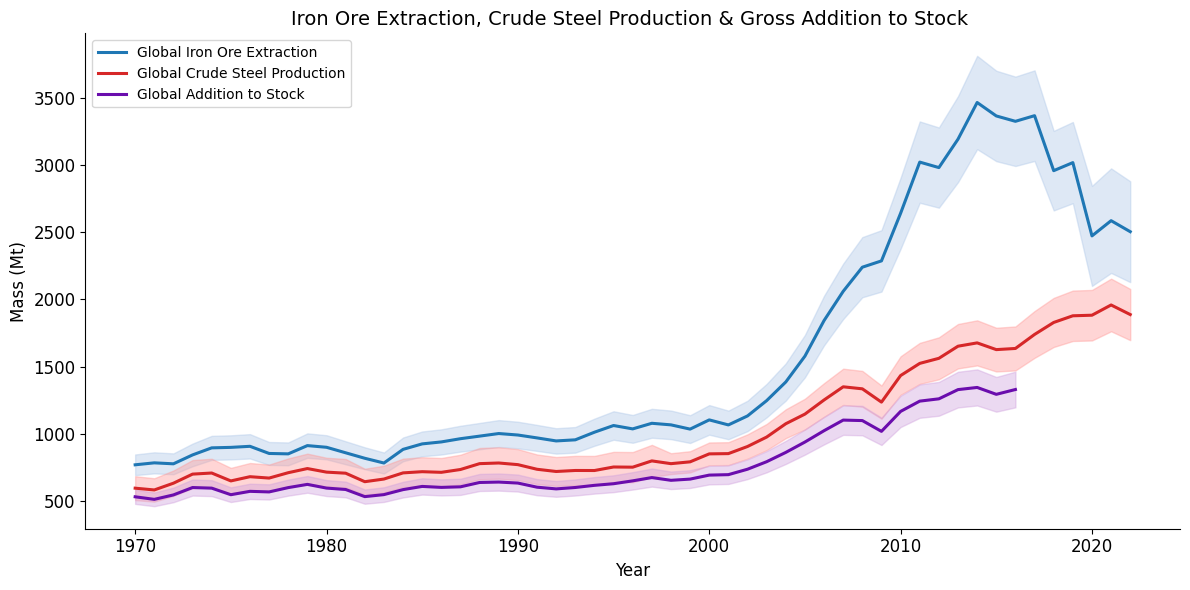

In [38]:
# Fixing the plotting issue: ensure 'year' is numeric and columns are numeric
# Convert year column to int
annual_summary_iron['year'] = pd.to_numeric(annual_summary_iron['year'], errors='coerce')
annual_summary_steel['year'] = pd.to_numeric(annual_summary_steel['year'], errors='coerce')
annual_summary_gas['year'] = pd.to_numeric(annual_summary_steel['year'], errors='coerce')

# Convert all other relevant columns to float
cols = ['global_iron', 'global_min', 'global_max']
annual_summary_iron[cols] = annual_summary_iron[cols].astype(float)

cols = ['global_steel', 'global_min', 'global_max']
annual_summary_steel[cols] = annual_summary_steel[cols].astype(float)

cols = ['GAS', 'global_min', 'global_max']
annual_summary_gas[cols] = annual_summary_gas[cols].astype(float)

# Re-run the plot
colors = {
    "iron": "#1f77b4",        # deep blue
    "iron_fill": "#aec7e8",   # light blue
    "steel": "#d62728",       # strong red
    "steel_fill": "#ff9896",   # pinkish fill
    "gas": "#6a0dad",       # strong red
    "gas_fill": "#cfa0dd"   # pinkish fill
}

plt.figure(figsize=(12, 6))

# Plot Iron Ore Extraction
plt.plot(annual_summary_iron['year'], annual_summary_iron['global_iron'],
         color=colors["iron"], linewidth=2.2, label='Global Iron Ore Extraction')
plt.fill_between(annual_summary_iron['year'],
                 annual_summary_iron['global_min'],
                 annual_summary_iron['global_max'],
                 color=colors["iron_fill"], alpha=0.4)

# Plot Crude Steel Production
plt.plot(annual_summary_steel['year'], annual_summary_steel['global_steel'],
         color=colors["steel"], linewidth=2.2, label='Global Crude Steel Production')
plt.fill_between(annual_summary_steel['year'],
                 annual_summary_steel['global_min'],
                 annual_summary_steel['global_max'],
                 color=colors["steel_fill"], alpha=0.4)

# Plot Crude Steel Production
plt.plot(annual_summary_gas['year'], annual_summary_gas['GAS'],
         color=colors["gas"], linewidth=2.2, label='Global Addition to Stock')
plt.fill_between(annual_summary_gas['year'],
                 annual_summary_gas['global_min'],
                 annual_summary_gas['global_max'],
                 color=colors["gas_fill"], alpha=0.4)

# Formatting
plt.xlabel("Year", fontsize=12)
plt.ylabel("Mass (Mt)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Iron Ore Extraction, Crude Steel Production & Gross Addition to Stock ", fontsize=14)
plt.legend(frameon=True, fontsize=10)
# plt.grid(True, linestyle='--', alpha=0.5)
for spine in ["top", "right"]:
    plt.gca().spines[spine].set_visible(False)
plt.tight_layout()
plt.savefig(plot_path + "Fig_S1.pdf", dpi=600)
plt.show()

# Figure 3

## iron ore

In [39]:
iron_ore_extraction = xr.open_dataset(netcdf_path + "L.iron_ore.2000-2022.a.nc").sel(time=slice('2000-01-01', '2016-01-01'))
iron_ore_extraction = iron_ore_extraction[["iron_ore", "iron_metal", "grid_area"]]
iron_ore_extraction

<xarray.Dataset> Size: 18MB
Dimensions:     (time: 17, lat: 180, lon: 360)
Coordinates:
  * lon         (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat         (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time        (time) datetime64[ns] 136B 2000-01-01 2001-01-01 ... 2016-01-01
Data variables:
    iron_ore    (time, lat, lon) float64 9MB ...
    iron_metal  (time, lat, lon) float64 9MB ...
    grid_area   (lat, lon) float64 518kB ...
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0

In [40]:
dfs = []
for year in iron_ore_extraction["time"].dt.year.values:
    print(year)
    year_str = f"{year}-01-01"
    df = ssm.grid_2_table(grid_data=iron_ore_extraction, time=year_str, grid_area=True, resolution=1, aggregation="region_2", agg_function='SUM', verbose=True)
    df["Year"] = year
    dfs.append(df)

2000
List of variables to process: ['iron_ore', 'iron_metal']
Global gridded stats for iron_ore: 1102284461309211.00
Global tabular stats for iron_ore: 1102284461309211.00
Global gridded stats for iron_metal: 597747246677485.88
Global tabular stats for iron_metal: 597747246677485.75
2001
List of variables to process: ['iron_ore', 'iron_metal']
Global gridded stats for iron_ore: 1064828247641602.00
Global tabular stats for iron_ore: 1064828247641602.00
Global gridded stats for iron_metal: 579295323748843.88
Global tabular stats for iron_metal: 579295323748844.00
2002
List of variables to process: ['iron_ore', 'iron_metal']
Global gridded stats for iron_ore: 1131775610339600.00
Global tabular stats for iron_ore: 1131775610339600.00
Global gridded stats for iron_metal: 612364412301714.38
Global tabular stats for iron_metal: 612364412301714.38
2003
List of variables to process: ['iron_ore', 'iron_metal']
Global gridded stats for iron_ore: 1245848254320724.75
Global tabular stats for iron_o

In [41]:
df_ex = pd.concat(dfs)
df_ex

region_2      iron_ore    iron_metal  Year
0   Australia and New Zealand  1.741998e+14  1.072510e+14  2000
1                   Caribbean  1.015000e+11  5.427565e+10  2000
2             Central America  1.144594e+13  6.874592e+12  2000
3                Central Asia  1.602235e+13  9.122295e+12  2000
4              Eastern Africa  1.006553e+12  5.829525e+11  2000
..                        ...           ...           ...   ...
17              Southern Asia  2.604784e+14  1.630267e+14  2016
18            Southern Europe  4.812934e+12  1.896219e+12  2016
19             Western Africa  2.144954e+13  1.302284e+13  2016
20               Western Asia  8.076151e+12  5.596545e+12  2016
21             Western Europe  2.400808e+12  6.645137e+11  2016

[374 rows x 4 columns]

In [42]:
# Create a list of columns to exclude from the operation
exclude_columns = ['region_2', 'Year']

# Multiply every other column by 1e-12
for column in df_ex.columns:
    if column not in exclude_columns:
        df_ex[column] *= 1e-12
        
df_ex

region_2    iron_ore  iron_metal  Year
0   Australia and New Zealand  174.199780  107.251022  2000
1                   Caribbean    0.101500    0.054276  2000
2             Central America   11.445940    6.874592  2000
3                Central Asia   16.022352    9.122295  2000
4              Eastern Africa    1.006553    0.582952  2000
..                        ...         ...         ...   ...
17              Southern Asia  260.478414  163.026665  2016
18            Southern Europe    4.812934    1.896219  2016
19             Western Africa   21.449542   13.022838  2016
20               Western Asia    8.076151    5.596545  2016
21             Western Europe    2.400808    0.664514  2016

[374 rows x 4 columns]

In [43]:
df_ex.sum()

region_2      Australia and New ZealandCaribbeanCentral Amer...
iron_ore                                           37936.449102
iron_metal                                         17702.749202
Year                                                     750992
dtype: object

In [44]:
region_mapping = {
    'Australia and New Zealand': 'Oceania',
    'Caribbean': 'Latin America and Caribbean',
    'Central America': 'Latin America and Caribbean',
    'Central Asia': 'Rest of Asia',
    'Eastern Africa': 'Africa',
    'Eastern Asia': 'Eastern Asia',
    'Eastern Europe': 'Europe',
    'Melanesia': 'Oceania',
    'Micronesia': 'Oceania',
    'Middle Africa': 'Africa',
    'Northern Africa': 'Africa',
    'Northern America': 'Northern America',
    'Northern Europe': 'Europe',
    'Polynesia': 'Oceania',
    'South America': 'Latin America and Caribbean',
    'South-eastern Asia': 'Rest of Asia',
    'Southern Africa': 'Africa',
    'Southern Asia': 'Rest of Asia',
    'Southern Europe': 'Europe',
    'Western Africa': 'Africa',
    'Western Asia': 'Rest of Asia',
    'Western Europe': 'Europe'
}


# Assuming df_ex_prod is your DataFrame
df_ex['Aggregate_Region'] = df_ex['region_2'].map(region_mapping)
# Replace 'Production' with the actual data column you want to sum
df_ex = df_ex.groupby(['Year', 'Aggregate_Region']).sum().reset_index()
df_ex

Year             Aggregate_Region  \
0    2000                       Africa   
1    2000                 Eastern Asia   
2    2000                       Europe   
3    2000  Latin America and Caribbean   
4    2000             Northern America   
..    ...                          ...   
114  2016                       Europe   
115  2016  Latin America and Caribbean   
116  2016             Northern America   
117  2016                      Oceania   
118  2016                 Rest of Asia   

                                              region_2    iron_ore  iron_metal  
0    Eastern AfricaMiddle AfricaNorthern AfricaSout...   52.328054   32.595958  
1                                         Eastern Asia  235.941961   73.322815  
2    Eastern EuropeNorthern EuropeSouthern EuropeWe...  171.912221   98.127103  
3                CaribbeanCentral AmericaSouth America  253.310586  152.125162  
4                                     Northern America   99.720438   64.398842  
..                                                 ...         ...         ...  
114  Eastern EuropeNorthern EuropeSouthern EuropeWe...  203.912097  121.397089  
115              CaribbeanCentral AmericaSouth America  474.771248  301.602585  
116                                   Northern America   90.796570   55.861508  
117  Australia and New ZealandMelanesiaMicronesiaPo...  861.521452  533.067670  
118  Central AsiaSouth-eastern AsiaSouthern AsiaWes...  313.548402  183.337772  

[119 rows x 5 columns]

In [45]:
df_ex.sum()

Year                                                           238952
Aggregate_Region    AfricaEastern AsiaEuropeLatin America and Cari...
region_2            Eastern AfricaMiddle AfricaNorthern AfricaSout...
iron_ore                                                 37936.449102
iron_metal                                               17702.749202
dtype: object

In [46]:
df_ex.to_csv(output_path + "extraction_by_region.csv", index=False)

In [47]:
df_ex = pd.read_csv(output_path + "extraction_by_region.csv")
df_ex = df_ex[["Year", "Aggregate_Region", "iron_ore", "iron_metal"]]
df_ex["residual"] = df_ex["iron_ore"] - df_ex["iron_metal"]
df_ex

Year             Aggregate_Region    iron_ore  iron_metal    residual
0    2000                       Africa   52.328054   32.595958   19.732096
1    2000                 Eastern Asia  235.941961   73.322815  162.619147
2    2000                       Europe  171.912221   98.127103   73.785118
3    2000  Latin America and Caribbean  253.310586  152.125162  101.185424
4    2000             Northern America   99.720438   64.398842   35.321596
..    ...                          ...         ...         ...         ...
114  2016                       Europe  203.912097  121.397089   82.515007
115  2016  Latin America and Caribbean  474.771248  301.602585  173.168662
116  2016             Northern America   90.796570   55.861508   34.935062
117  2016                      Oceania  861.521452  533.067670  328.453782
118  2016                 Rest of Asia  313.548402  183.337772  130.210630

[119 rows x 5 columns]

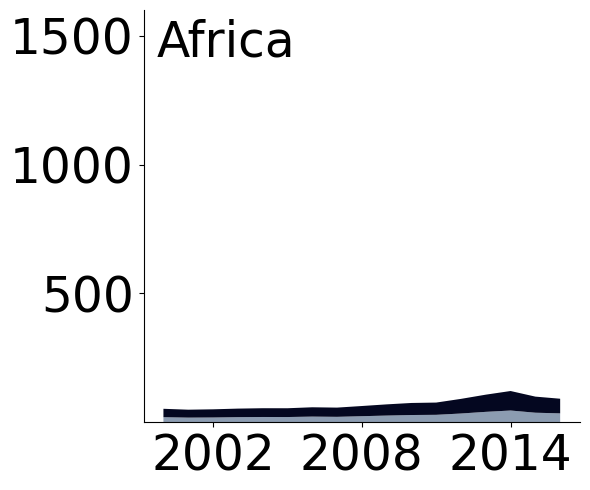

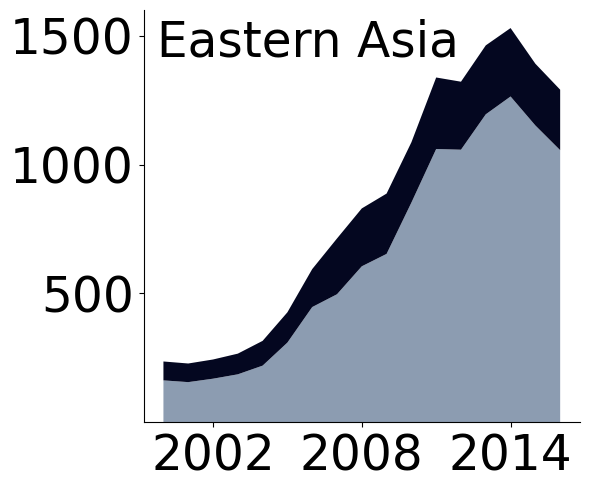

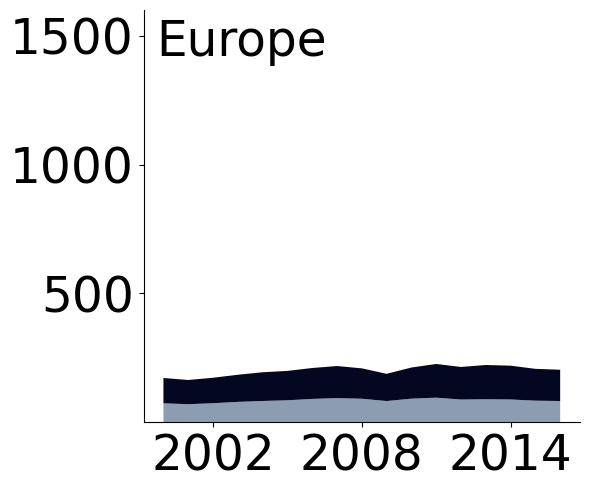

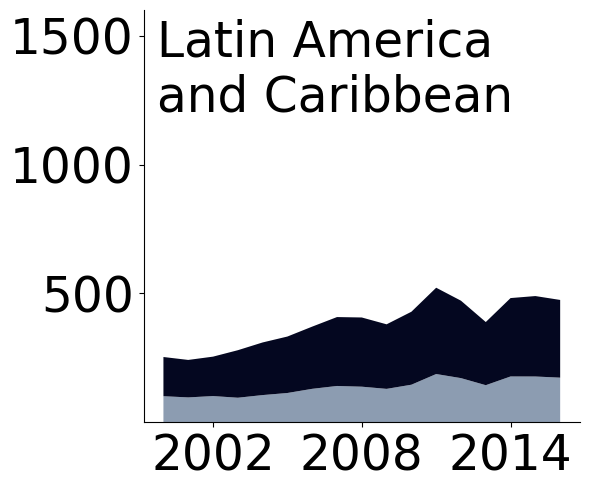

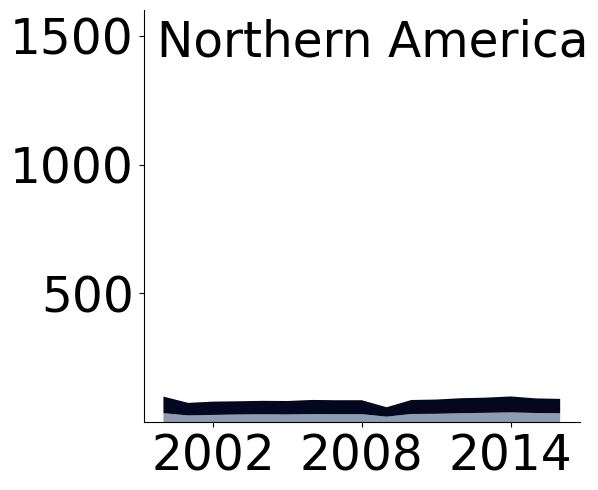

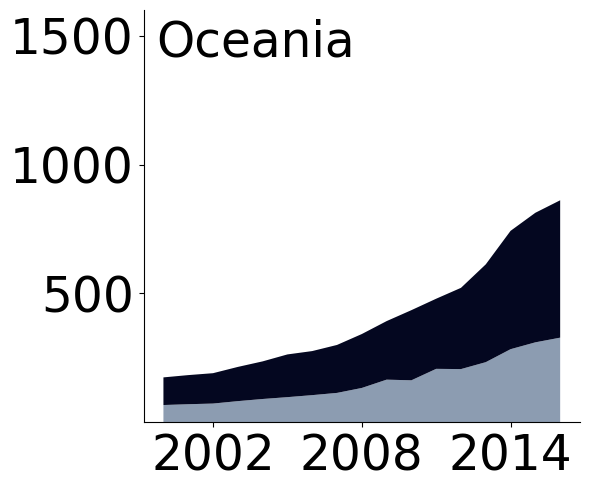

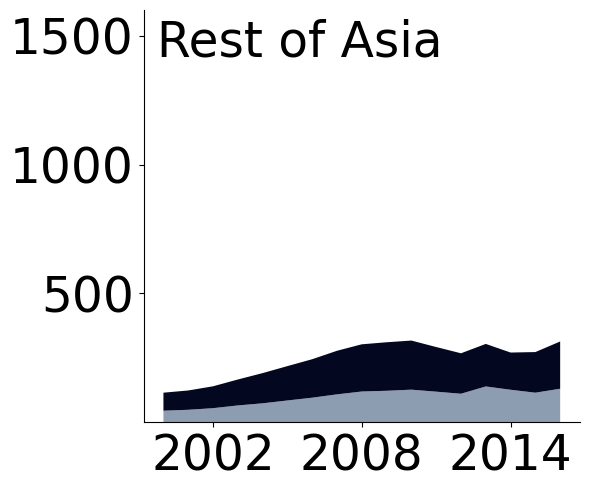

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume df_steel is your DataFrame
regions = df_ex['Aggregate_Region'].unique()

# Colors for the areas
colors = ['#8c9cb1', '#040720']

# Loop through each region
for region in regions:
    plt.figure(figsize=(6, 5))  # Create a new figure for each plot

    # Filter data for the entire timeframe for the region
    df_filtered = df_ex[df_ex['Aggregate_Region'] == region]
    df_filtered = df_filtered.drop(columns=["Aggregate_Region"])
    
    # Apply a rolling mean with a window size, e.g., 3 years
    window_size = 1  # Adjust the window size to increase or decrease smoothing
    df_smoothed = df_filtered.set_index('Year').rolling(window=window_size, min_periods=1, center=True).mean()

    # Prepare data for plotting
    years = df_smoothed.index
    iron_metal = df_smoothed['iron_metal'] 
    residual = df_smoothed['residual']

    # Create stack plot
    plt.stackplot(years, residual, iron_metal, labels=['Residuals', 'Available Fe Content'], colors=colors)

    # Customize the axes and spines
    ax = plt.gca()  # Get current axes
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    
    # # Place the region name
    # ax.text(0.05, 0.95, region, horizontalalignment='left', transform=ax.transAxes, fontsize=25, fontweight='bold')

    if region == "Latin America and Caribbean":
        display_name = "Latin America\nand Caribbean"
    else:
        display_name = region

    ax.text(
        0.03, 0.98, 
        display_name, 
        ha='left', va='top', 
        transform=ax.transAxes, 
        fontsize=35, # fontweight='bold'
    )
    
    ax.set_ylim(0, 1600)
    yticks = [500, 1000, 1500]
    ax.set_yticks(yticks)
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    # Keep x-axis as before
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))

    # Customize the fontsize of x and y-axis tick labels
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(35)  # Set font size
        # label.set_fontweight('bold')  # Set font weight to bold
    
    
    # Save the figure with a transparent backgroundFe 
    filename = f'iron_ore_{region}_{2000}_{2016}.pdf'
    plt.savefig(plot_path + filename, transparent=True, bbox_inches='tight', dpi=600)

    # Show the plot
    plt.tight_layout()
    plt.show()
    plt.close()  # Close the figure to free up memory


## steel

In [49]:
crude_steel_production = xr.open_dataset(netcdf_path + "T.steel.2000-2022.a.nc").sel(time=slice('2000-01-01', '2016-01-01'))
crude_steel_production = crude_steel_production.drop_vars(["steel_plants"])
crude_steel_production

<xarray.Dataset> Size: 45MB
Dimensions:                    (lon: 360, lat: 180, time: 17)
Coordinates:
  * lon                        (lon) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * lat                        (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * time                       (time) datetime64[ns] 136B 2000-01-01 ... 2016...
Data variables:
    grid_area                  (lat, lon) float64 518kB ...
    land_frac                  (lat, lon) float64 518kB ...
    crude_steel                (time, lat, lon) float64 9MB ...
    crude_steel_from_scrap     (time, lat, lon) float64 9MB ...
    crude_steel_from_iron_ore  (time, lat, lon) float64 9MB ...
    pre_consumer_scrap         (time, lat, lon) float64 9MB ...
    post_consumer_scrap        (time, lat, lon) float64 9MB ...
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0

In [50]:
dfs = []
for year in crude_steel_production["time"].dt.year.values:
    print(year)
    year_str = f"{year}-01-01"
    df = ssm.grid_2_table(grid_data=crude_steel_production, time=year_str, grid_area=True, resolution=1, aggregation="region_2", agg_function='SUM', verbose=True)
    df["Year"] = year
    dfs.append(df)

2000
List of variables to process: ['crude_steel', 'crude_steel_from_scrap', 'crude_steel_from_iron_ore', 'pre_consumer_scrap', 'post_consumer_scrap']
Global gridded stats for crude_steel: 849145127833333.25
Global tabular stats for crude_steel: 849145127833333.38
Global gridded stats for crude_steel_from_scrap: 368929631380731.75
Global tabular stats for crude_steel_from_scrap: 368929631380731.81
Global gridded stats for crude_steel_from_iron_ore: 480215496452601.56
Global tabular stats for crude_steel_from_iron_ore: 480215496452601.56
Global gridded stats for pre_consumer_scrap: 195532704631787.81
Global tabular stats for pre_consumer_scrap: 195532704631787.84
Global gridded stats for post_consumer_scrap: 173396926748943.88
Global tabular stats for post_consumer_scrap: 173396926748943.91
2001
List of variables to process: ['crude_steel', 'crude_steel_from_scrap', 'crude_steel_from_iron_ore', 'pre_consumer_scrap', 'post_consumer_scrap']
Global gridded stats for crude_steel: 8510673723

In [51]:
df_prod = pd.concat(dfs)
df_prod

region_2   crude_steel  crude_steel_from_scrap  \
0   Australia and New Zealand  7.915000e+12            3.468353e+12   
1                   Caribbean  1.093265e+12            4.797486e+11   
2             Central America  1.583866e+13            6.940502e+12   
3                Central Asia  5.202864e+12            2.250789e+12   
4              Eastern Africa  2.996791e+11            1.313194e+11   
..                        ...           ...                     ...   
17              Southern Asia  1.204530e+14            4.676928e+13   
18            Southern Europe  4.434750e+13            3.406125e+13   
19             Western Africa  3.550000e+11            1.378465e+11   
20               Western Asia  4.744827e+13            3.095006e+13   
21             Western Europe  8.134326e+13            3.441945e+13   

    crude_steel_from_iron_ore  pre_consumer_scrap  post_consumer_scrap  Year  
0                4.446647e+12        1.838227e+12         1.630126e+12  2000  
1                6.135165e+11        2.542667e+11         2.254818e+11  2000  
2                8.898160e+12        3.678466e+12         3.262036e+12  2000  
3                2.952075e+12        1.192918e+12         1.057871e+12  2000  
4                1.683597e+11        6.959928e+10         6.172011e+10  2000  
..                        ...                 ...                  ...   ...  
17               7.368376e+13        2.011079e+13         2.665849e+13  2016  
18               1.028626e+13        1.464634e+13         1.941491e+13  2016  
19               2.171535e+11        5.927400e+10         7.857250e+10  2016  
20               1.649821e+13        1.330853e+13         1.764154e+13  2016  
21               4.692380e+13        1.480037e+13         1.961909e+13  2016  

[374 rows x 7 columns]

In [52]:
# Create a list of columns to exclude from the operation
exclude_columns = ['region_2', 'Year']

# Multiply every other column by 1e-12
for column in df_prod.columns:
    if column not in exclude_columns:
        df_prod[column] *= 1e-12
        
df_prod

region_2  crude_steel  crude_steel_from_scrap  \
0   Australia and New Zealand     7.915000                3.468353   
1                   Caribbean     1.093265                0.479749   
2             Central America    15.838662                6.940502   
3                Central Asia     5.202864                2.250789   
4              Eastern Africa     0.299679                0.131319   
..                        ...          ...                     ...   
17              Southern Asia   120.453042               46.769277   
18            Southern Europe    44.347504               34.061249   
19             Western Africa     0.355000                0.137847   
20               Western Asia    47.448273               30.950062   
21             Western Europe    81.343256               34.419454   

    crude_steel_from_iron_ore  pre_consumer_scrap  post_consumer_scrap  Year  
0                    4.446647            1.838227             1.630126  2000  
1                    0.613517            0.254267             0.225482  2000  
2                    8.898160            3.678466             3.262036  2000  
3                    2.952075            1.192918             1.057871  2000  
4                    0.168360            0.069599             0.061720  2000  
..                        ...                 ...                  ...   ...  
17                  73.683765           20.110789            26.658488  2016  
18                  10.286255           14.646337            19.414912  2016  
19                   0.217153            0.059274             0.078573  2016  
20                  16.498211           13.308526            17.641535  2016  
21                  46.923802           14.800365            19.619089  2016  

[374 rows x 7 columns]

In [53]:
df_prod.sum()

region_2                     Australia and New ZealandCaribbeanCentral Amer...
crude_steel                                                        22070.24386
crude_steel_from_scrap                                             7367.790476
crude_steel_from_iron_ore                                         14702.453384
pre_consumer_scrap                                                 3718.086923
post_consumer_scrap                                                3649.703553
Year                                                                    750992
dtype: object

In [54]:
region_mapping = {
    'Australia and New Zealand': 'Oceania',
    'Caribbean': 'Latin America and Caribbean',
    'Central America': 'Latin America and Caribbean',
    'Central Asia': 'Rest of Asia',
    'Eastern Africa': 'Africa',
    'Eastern Asia': 'Eastern Asia',
    'Eastern Europe': 'Europe',
    'Melanesia': 'Oceania',
    'Micronesia': 'Oceania',
    'Middle Africa': 'Africa',
    'Northern Africa': 'Africa',
    'Northern America': 'Northern America',
    'Northern Europe': 'Europe',
    'Polynesia': 'Oceania',
    'South America': 'Latin America and Caribbean',
    'South-eastern Asia': 'Rest of Asia',
    'Southern Africa': 'Africa',
    'Southern Asia': 'Rest of Asia',
    'Southern Europe': 'Europe',
    'Western Africa': 'Africa',
    'Western Asia': 'Rest of Asia',
    'Western Europe': 'Europe'
}


# Assuming df_ex_prod is your DataFrame
df_prod['Aggregate_Region'] = df_prod['region_2'].map(region_mapping)
# Replace 'Production' with the actual data column you want to sum
df_prod = df_prod.groupby(['Year', 'Aggregate_Region']).sum().reset_index()
df_prod

Year             Aggregate_Region  \
0    2000                       Africa   
1    2000                 Eastern Asia   
2    2000                       Europe   
3    2000  Latin America and Caribbean   
4    2000             Northern America   
..    ...                          ...   
114  2016                       Europe   
115  2016  Latin America and Caribbean   
116  2016             Northern America   
117  2016                      Oceania   
118  2016                 Rest of Asia   

                                              region_2  crude_steel  \
0    Eastern AfricaMiddle AfricaNorthern AfricaSout...    13.822946   
1                                         Eastern Asia   295.582802   
2    Eastern EuropeNorthern EuropeSouthern EuropeWe...   289.366292   
3                CaribbeanCentral AmericaSouth America    56.392195   
4                                     Northern America   118.359169   
..                                                 ...          ...   
114  Eastern EuropeNorthern EuropeSouthern EuropeWe...   262.918440   
115              CaribbeanCentral AmericaSouth America    60.460020   
116                                   Northern America    91.121000   
117  Australia and New ZealandMelanesiaMicronesiaPo...     5.836000   
118  Central AsiaSouth-eastern AsiaSouthern AsiaWes...   195.516689   

     crude_steel_from_scrap  crude_steel_from_iron_ore  pre_consumer_scrap  \
0                  6.059969                   7.762976            3.211784   
1                 82.917166                 212.665636           43.946098   
2                138.466331                 150.899961           73.387156   
3                 24.713323                  31.678872           13.098061   
4                 77.944816                  40.414354           41.310752   
..                      ...                        ...                 ...   
114              124.805224                 138.113216           53.666246   
115               23.479179                  36.980841           10.096047   
116               61.569392                  29.551608           26.474838   
117                2.266119                   3.569881            0.974431   
118               88.333852                 107.182837           37.983556   

     post_consumer_scrap  
0               2.848186  
1              38.971068  
2              65.079176  
3              11.615262  
4              36.634063  
..                   ...  
114            71.138978  
115            13.383132  
116            35.094553  
117             1.291688  
118            50.350296  

[119 rows x 8 columns]

In [55]:
df_prod.sum()

Year                                                                    238952
Aggregate_Region             AfricaEastern AsiaEuropeLatin America and Cari...
region_2                     Eastern AfricaMiddle AfricaNorthern AfricaSout...
crude_steel                                                        22070.24386
crude_steel_from_scrap                                             7367.790476
crude_steel_from_iron_ore                                         14702.453384
pre_consumer_scrap                                                 3718.086923
post_consumer_scrap                                                3649.703553
dtype: object

In [56]:
df_prod.to_csv(output_path + "production_by_region.csv", index=False)

In [57]:
df_prod = pd.read_csv(output_path + "production_by_region.csv")
df_prod = df_prod[["Year", "Aggregate_Region", "crude_steel", "crude_steel_from_iron_ore", "pre_consumer_scrap", "post_consumer_scrap"]]
df_prod

Year             Aggregate_Region  crude_steel  \
0    2000                       Africa    13.822946   
1    2000                 Eastern Asia   295.582802   
2    2000                       Europe   289.366292   
3    2000  Latin America and Caribbean    56.392195   
4    2000             Northern America   118.359169   
..    ...                          ...          ...   
114  2016                       Europe   262.918440   
115  2016  Latin America and Caribbean    60.460020   
116  2016             Northern America    91.121000   
117  2016                      Oceania     5.836000   
118  2016                 Rest of Asia   195.516689   

     crude_steel_from_iron_ore  pre_consumer_scrap  post_consumer_scrap  
0                     7.762976            3.211784             2.848186  
1                   212.665636           43.946098            38.971068  
2                   150.899961           73.387156            65.079176  
3                    31.678872           13.098061            11.615262  
4                    40.414354           41.310752            36.634063  
..                         ...                 ...                  ...  
114                 138.113216           53.666246            71.138978  
115                  36.980841           10.096047            13.383132  
116                  29.551608           26.474838            35.094553  
117                   3.569881            0.974431             1.291688  
118                 107.182837           37.983556            50.350296  

[119 rows x 6 columns]

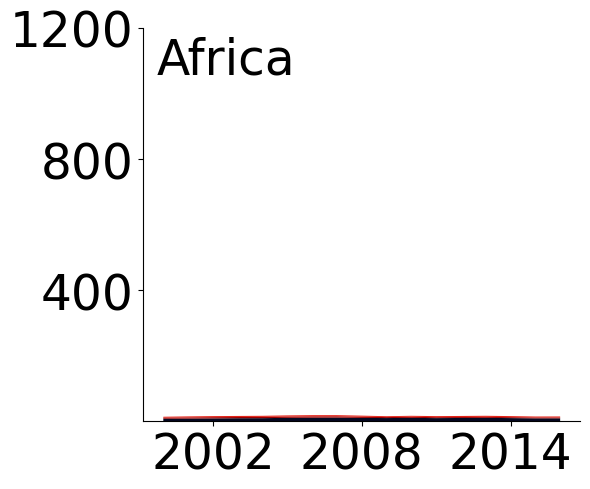

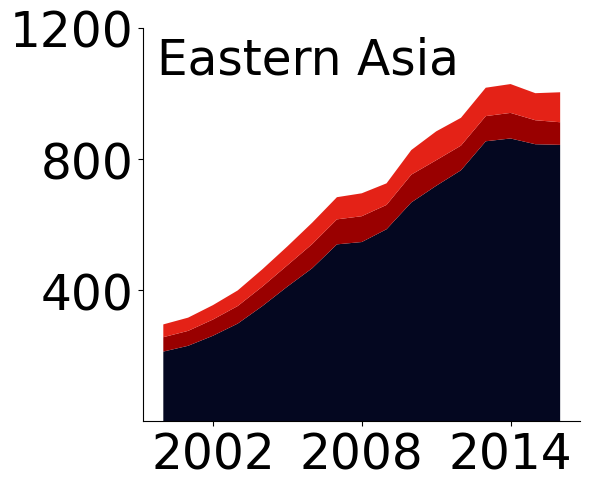

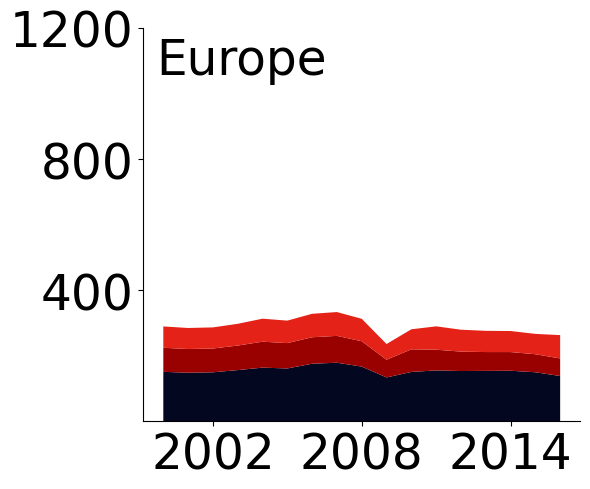

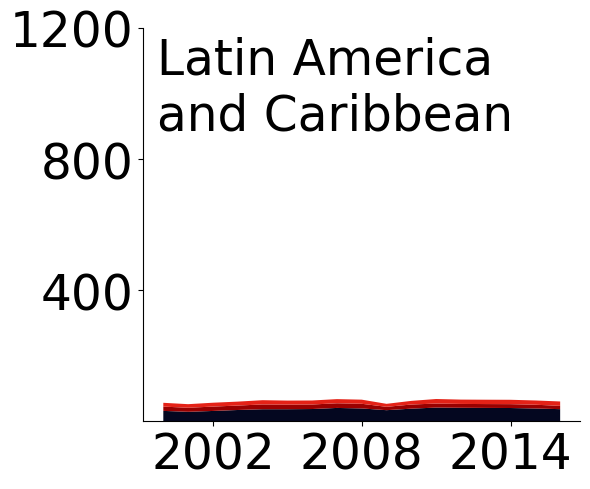

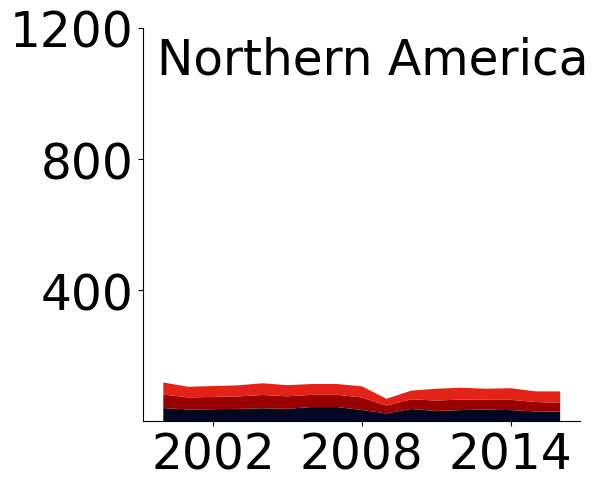

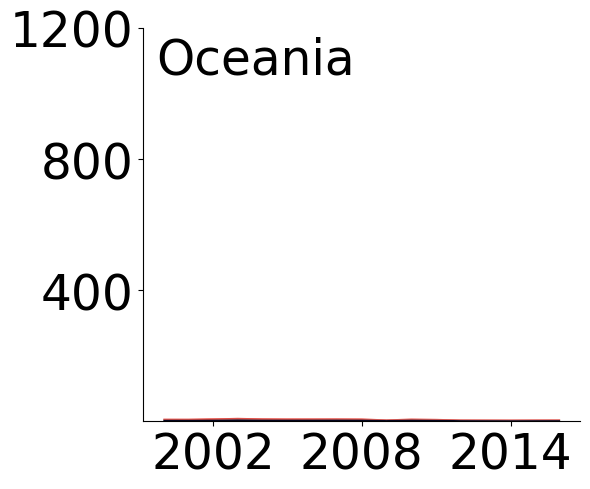

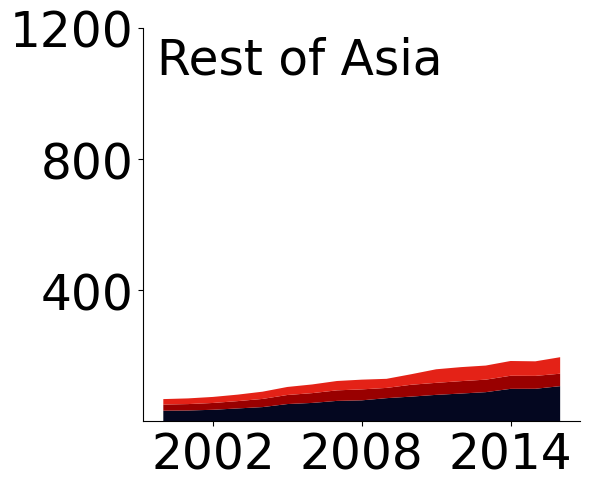

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter

# Assume df_steel is your DataFrame
regions = df_prod['Aggregate_Region'].unique()

# Colors for the areas
colors = ['#040720', '#990000', '#E42217']

# Function to format the tick labels as powers of ten
def log_tick_formatter(val, pos):
    return f'$10^{{{int(val)}}}$' if val != 0 else '1'

# Loop through each region
for region in regions:
    plt.figure(figsize=(6, 5))  # Create a new figure for each plot

    # Filter data for the entire timeframe for the region
    df_filtered = df_prod[df_prod['Aggregate_Region'] == region]
    df_filtered = df_filtered.drop(columns=["Aggregate_Region"])

    # Apply a rolling mean with a window size, e.g., 3 years
    window_size = 1  # Adjust the window size to increase or decrease smoothing
    df_smoothed = df_filtered.set_index('Year').rolling(window=window_size, min_periods=1, center=True).mean()

    # Prepare data for plotting
    years = df_smoothed.index
    iron_ore = df_smoothed['crude_steel_from_iron_ore']
    pre_consumer = df_smoothed['pre_consumer_scrap']
    post_consumer = df_smoothed['post_consumer_scrap']

    # Create stack plot
    plt.stackplot(years, iron_ore, pre_consumer, post_consumer, labels=['Iron Ore', 'Pre-consumer Scrap', 'Post-consumer Scrap'], colors=colors)

    # Customize the axes and spines
    ax = plt.gca()  # Get current axes
    # ax.set_yscale('log', base=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    
    if region == "Latin America and Caribbean":
        display_name = "Latin America\nand Caribbean"
    else:
        display_name = region

    ax.text(
        0.03, 0.98, 
        display_name, 
        ha='left', va='top', 
        transform=ax.transAxes, 
        fontsize=35, # fontweight='bold'
    )
    
    ax.set_ylim(0, 1100)
    yticks = [400, 800, 1200]
    ax.set_yticks(yticks)
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    
    # ax.yaxis.set_major_locator(plt.MaxNLocator(5))  # Adjust the number 5 to your preference
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))  # Adjust the number 5 to your preference

    # Customize the fontsize of x and y-axis tick labels
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(35)  # Set font size
        # label.set_fontweight('bold')  # Set font weight to bold

        
    # # Save the figure with a transparent background
    filename = f'steel_{region}_{2000}_{2016}.pdf'
    plt.savefig(plot_path + filename, transparent=True, bbox_inches='tight', dpi=600)

    # Show the plot
    plt.tight_layout()
    plt.show()
    plt.close()  # Close the figure to free up memory


## gross addition to stock

In [59]:
gas = xr.open_dataset(netcdf_path + "T.iron_enduse.gas.2000-2016.a.nc")
gas = gas.drop_vars("GAS_total")
gas

<xarray.Dataset> Size: 116MB
Dimensions:                                     (lon: 360, lat: 180, time: 17)
Coordinates:
  * lon                                         (lon) float64 3kB -179.5 ... ...
  * lat                                         (lat) float64 1kB -89.5 ... 89.5
  * time                                        (time) datetime64[ns] 136B 20...
Data variables: (12/15)
    land_frac                                   (lat, lon) float64 518kB ...
    grid_area                                   (lat, lon) float64 518kB ...
    Civil_engineering_except_roads              (time, lat, lon) float64 9MB ...
    Computers_and_precision_instruments         (time, lat, lon) float64 9MB ...
    Electrical_equipment                        (time, lat, lon) float64 9MB ...
    Food_packaging                              (time, lat, lon) float64 9MB ...
    ...                                          ...
    Non_residential_buildings                   (time, lat, lon) float64 9MB ...
    Other_transport_equipment                   (time, lat, lon) float64 9MB ...
    Printed_matter_and_recorded_media           (time, lat, lon) float64 9MB ...
    Products_nec                                (time, lat, lon) float64 9MB ...
    Residential_buildings                       (time, lat, lon) float64 9MB ...
    Textiles                                    (time, lat, lon) float64 9MB ...
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0

In [60]:
dfs = []
for year in gas["time"].dt.year.values:
    print(year)
    year_str = f"{year}-01-01"
    df = ssm.grid_2_table(grid_data=gas, time=year_str, grid_area=True, resolution=1, aggregation="region_2", agg_function='SUM', verbose=True)
    df["Year"] = year
    dfs.append(df)
    
df_gas_flux = pd.concat(dfs)
df_gas_flux

2000
List of variables to process: ['Civil_engineering_except_roads', 'Computers_and_precision_instruments', 'Electrical_equipment', 'Food_packaging', 'Furniture_and_other_manufactured_goods_nec', 'Machinery_and_equipment', 'Motor_vehicles_trailers_and_semi-trailers', 'Non_residential_buildings', 'Other_transport_equipment', 'Printed_matter_and_recorded_media', 'Products_nec', 'Residential_buildings', 'Textiles']
Global gridded stats for Civil_engineering_except_roads: 240974721099775.97
Global tabular stats for Civil_engineering_except_roads: 240974721099775.97
Global gridded stats for Computers_and_precision_instruments: 8035244280521.69
Global tabular stats for Computers_and_precision_instruments: 8035244280521.69
Global gridded stats for Electrical_equipment: 10277445688985.13
Global tabular stats for Electrical_equipment: 10277445688985.13
Global gridded stats for Food_packaging: 19681330345068.98
Global tabular stats for Food_packaging: 19681330345068.98
Global gridded stats for 

region_2  Civil_engineering_except_roads  \
0   Australia and New Zealand                    9.279623e+11   
1                   Caribbean                    1.171848e+12   
2             Central America                    9.226046e+12   
3                Central Asia                    1.180991e+12   
4              Eastern Africa                    7.045664e+11   
..                        ...                             ...   
17              Southern Asia                    3.457405e+13   
18            Southern Europe                    1.322187e+13   
19             Western Africa                    2.944254e+12   
20               Western Asia                    2.128463e+13   
21             Western Europe                    1.942853e+13   

    Computers_and_precision_instruments  Electrical_equipment  Food_packaging  \
0                          4.762486e+10          1.316968e+11    2.672647e+11   
1                          2.867690e+10          2.683671e+10    7.134630e+10   
2                          3.112217e+11          4.176360e+11    6.754792e+11   
3                          3.701981e+10          8.842149e+10    1.281646e+11   
4                          1.584741e+10          2.335263e+10    6.427619e+10   
..                                  ...                   ...             ...   
17                         6.622104e+11          2.973408e+12    3.836397e+12   
18                         2.925542e+11          4.835648e+11    1.067456e+12   
19                         7.543393e+10          9.805884e+10    2.760839e+11   
20                         5.527724e+11          7.452391e+11    2.552290e+12   
21                         4.884339e+11          1.064343e+12    2.136281e+12   

    Furniture_and_other_manufactured_goods_nec  Machinery_and_equipment  \
0                                 1.163665e+11             7.235371e+11   
1                                 5.314575e+10             2.891217e+11   
2                                 4.405097e+11             1.248667e+12   
3                                 6.545001e+10             3.966734e+11   
4                                 2.686891e+10             2.289515e+11   
..                                         ...                      ...   
17                                2.517462e+12             1.458877e+13   
18                                5.497845e+11             3.891210e+12   
19                                1.211878e+11             1.137235e+12   
20                                5.851478e+11             1.173950e+13   
21                                1.135502e+12             8.094832e+12   

    Motor_vehicles_trailers_and_semi-trailers  Non_residential_buildings  \
0                                9.944904e+11               1.167750e+12   
1                                3.405965e+11               2.432896e+11   
2                                3.071025e+12               1.676609e+12   
3                                4.084791e+11               3.021568e+11   
4                                2.117825e+11               1.248449e+11   
..                                        ...                        ...   
17                               2.025368e+13               9.746921e+12   
18                               4.247990e+12               2.599185e+12   
19                               9.879993e+11               8.555872e+11   
20                               1.131848e+13               5.689253e+12   
21                               1.215493e+13               4.182952e+12   

    Other_transport_equipment  Printed_matter_and_recorded_media  \
0                1.300081e+11                       4.909285e+10   
1                1.809556e+11                       3.249764e+09   
2                5.635699e+11                       1.016813e+10   
3                9.433084e+10                       1.813365e+09   
4                5.854043e+10                       4.478094e+09   
..                        ...                

In [61]:
# Create a list of columns to exclude from the operation
exclude_columns = ['region_2', 'Year']

# Multiply every other column by 1e-12
for column in df_gas_flux.columns:
    if column not in exclude_columns:
        df_gas_flux[column] *= 1e-12
        
df_gas_flux

region_2  Civil_engineering_except_roads  \
0   Australia and New Zealand                        0.927962   
1                   Caribbean                        1.171848   
2             Central America                        9.226046   
3                Central Asia                        1.180991   
4              Eastern Africa                        0.704566   
..                        ...                             ...   
17              Southern Asia                       34.574045   
18            Southern Europe                       13.221868   
19             Western Africa                        2.944254   
20               Western Asia                       21.284633   
21             Western Europe                       19.428527   

    Computers_and_precision_instruments  Electrical_equipment  Food_packaging  \
0                              0.047625              0.131697        0.267265   
1                              0.028677              0.026837        0.071346   
2                              0.311222              0.417636        0.675479   
3                              0.037020              0.088421        0.128165   
4                              0.015847              0.023353        0.064276   
..                                  ...                   ...             ...   
17                             0.662210              2.973408        3.836397   
18                             0.292554              0.483565        1.067456   
19                             0.075434              0.098059        0.276084   
20                             0.552772              0.745239        2.552290   
21                             0.488434              1.064343        2.136281   

    Furniture_and_other_manufactured_goods_nec  Machinery_and_equipment  \
0                                     0.116366                 0.723537   
1                                     0.053146                 0.289122   
2                                     0.440510                 1.248667   
3                                     0.065450                 0.396673   
4                                     0.026869                 0.228952   
..                                         ...                      ...   
17                                    2.517462                14.588767   
18                                    0.549784                 3.891210   
19                                    0.121188                 1.137235   
20                                    0.585148                11.739497   
21                                    1.135502                 8.094832   

    Motor_vehicles_trailers_and_semi-trailers  Non_residential_buildings  \
0                                    0.994490                   1.167750   
1                                    0.340597                   0.243290   
2                                    3.071025                   1.676609   
3                                    0.408479                   0.302157   
4                                    0.211782                   0.124845   
..                                        ...                        ...   
17                                  20.253679                   9.746921   
18                                   4.247990                   2.599185   
19                                   0.987999                   0.855587   
20                                  11.318481                   5.689253   
21                                  12.154926                   4.182952   

    Other_transport_equipment  Printed_matter_and_recorded_media  \
0                    0.130008                           0.049093   
1                    0.180956                           0.003250   
2                    0.563570                           0.010168   
3                    0.094331                           0.001813   
4                    0.058540                           0.004478   
..                        ...                

In [62]:
df_gas_flux.sum()

region_2                                      Australia and New ZealandCaribbeanCentral Amer...
Civil_engineering_except_roads                                                      7153.924596
Computers_and_precision_instruments                                                  228.454025
Electrical_equipment                                                                 260.482639
Food_packaging                                                                       468.622907
Furniture_and_other_manufactured_goods_nec                                           256.224879
Machinery_and_equipment                                                             2342.794541
Motor_vehicles_trailers_and_semi-trailers                                           2248.791561
Non_residential_buildings                                                           1525.900107
Other_transport_equipment                                                            1085.33549
Printed_matter_and_recorded_media       

In [63]:
region_mapping = {
    'Australia and New Zealand': 'Oceania',
    'Caribbean': 'Latin America and Caribbean',
    'Central America': 'Latin America and Caribbean',
    'Central Asia': 'Rest of Asia',
    'Eastern Africa': 'Africa',
    'Eastern Asia': 'Eastern Asia',
    'Eastern Europe': 'Europe',
    'Melanesia': 'Oceania',
    'Micronesia': 'Oceania',
    'Middle Africa': 'Africa',
    'Northern Africa': 'Africa',
    'Northern America': 'Northern America',
    'Northern Europe': 'Europe',
    'Polynesia': 'Oceania',
    'South America': 'Latin America and Caribbean',
    'South-eastern Asia': 'Rest of Asia',
    'Southern Africa': 'Africa',
    'Southern Asia': 'Rest of Asia',
    'Southern Europe': 'Europe',
    'Western Africa': 'Africa',
    'Western Asia': 'Rest of Asia',
    'Western Europe': 'Europe'
}


# Assuming df_ex_prod is your DataFrame
df_gas_flux['Aggregate_Region'] = df_gas_flux['region_2'].map(region_mapping)
# Replace 'Production' with the actual data column you want to sum
df_gas_flux = df_gas_flux.groupby(['Year', 'Aggregate_Region']).sum().reset_index()
df_gas_flux

Year             Aggregate_Region  \
0    2000                       Africa   
1    2000                 Eastern Asia   
2    2000                       Europe   
3    2000  Latin America and Caribbean   
4    2000             Northern America   
..    ...                          ...   
114  2016                       Europe   
115  2016  Latin America and Caribbean   
116  2016             Northern America   
117  2016                      Oceania   
118  2016                 Rest of Asia   

                                              region_2  \
0    Eastern AfricaMiddle AfricaNorthern AfricaSout...   
1                                         Eastern Asia   
2    Eastern EuropeNorthern EuropeSouthern EuropeWe...   
3                CaribbeanCentral AmericaSouth America   
4                                     Northern America   
..                                                 ...   
114  Eastern EuropeNorthern EuropeSouthern EuropeWe...   
115              CaribbeanCentral AmericaSouth America   
116                                   Northern America   
117  Australia and New ZealandMelanesiaMicronesiaPo...   
118  Central AsiaSouth-eastern AsiaSouthern AsiaWes...   

     Civil_engineering_except_roads  Computers_and_precision_instruments  \
0                          6.968830                             0.186235   
1                         94.335845                             3.061293   
2                         63.706527                             1.662447   
3                         21.887694                             0.773954   
4                         24.171528                             1.533203   
..                              ...                                  ...   
114                       64.695882                             1.762116   
115                       29.573643                             1.032456   
116                       21.609529                             1.420932   
117                        1.797046                             0.120850   
118                       88.063537                             2.672040   

     Electrical_equipment  Food_packaging  \
0                0.265473        0.704931   
1                2.795053        2.526408   
2                2.908329        8.560265   
3                0.684284        2.049508   
4                1.408147        2.095886   
..                    ...             ...   
114              2.796335        9.895195   
115              0.839145        3.015531   
116              1.277172        2.545892   
117              0.261092        0.686562   
118              6.039892        9.013535   

     Furniture_and_other_manufactured_goods_nec  Machinery_and_equipment  \
0                                      0.286319                 2.722152   
1                                      2.159891                28.095329   
2                                      3.208976                25.682179   
3                                      1.023915                 4.931125   
4                                      2.745312                16.586858   
..                                          ...                      ...   
114                                    2.911126                27.474465   
115                                    1.255835                 6.648699   
116                                    2.414910                16.740770   
117                                    0.231164                 1.646669   
118                                    4.773890                37.997129   

     Motor_vehicles_trailers_and_semi-trailers  Non_residential_buildings  \
0                                     2.426858                   2.515993   
1                                    19.692956                  15.155865   
2                                    32.186325                  15.980337   
3                                     6.892128                   5.009059   
4                                    24.605596     

In [64]:
df_gas_flux.sum()

Year                                                                                     238952
Aggregate_Region                              AfricaEastern AsiaEuropeLatin America and Cari...
region_2                                      Eastern AfricaMiddle AfricaNorthern AfricaSout...
Civil_engineering_except_roads                                                      7153.924596
Computers_and_precision_instruments                                                  228.454025
Electrical_equipment                                                                 260.482639
Food_packaging                                                                       468.622907
Furniture_and_other_manufactured_goods_nec                                           256.224879
Machinery_and_equipment                                                             2342.794541
Motor_vehicles_trailers_and_semi-trailers                                           2248.791561
Non_residential_buildings               

In [65]:
# Melt the dataframe to bring sector columns under a single column named "sector"
df_melted = df_gas_flux.melt(id_vars=["Year", "region_2", "Aggregate_Region"], 
                             var_name="sector", 
                             value_name="flow")
df_melted

Year                                           region_2  \
0     2000  Eastern AfricaMiddle AfricaNorthern AfricaSout...   
1     2000                                       Eastern Asia   
2     2000  Eastern EuropeNorthern EuropeSouthern EuropeWe...   
3     2000              CaribbeanCentral AmericaSouth America   
4     2000                                   Northern America   
...    ...                                                ...   
1542  2016  Eastern EuropeNorthern EuropeSouthern EuropeWe...   
1543  2016              CaribbeanCentral AmericaSouth America   
1544  2016                                   Northern America   
1545  2016  Australia and New ZealandMelanesiaMicronesiaPo...   
1546  2016  Central AsiaSouth-eastern AsiaSouthern AsiaWes...   

                 Aggregate_Region                          sector       flow  
0                          Africa  Civil_engineering_except_roads   6.968830  
1                    Eastern Asia  Civil_engineering_except_roads  94.335845  
2                          Europe  Civil_engineering_except_roads  63.706527  
3     Latin America and Caribbean  Civil_engineering_except_roads  21.887694  
4                Northern America  Civil_engineering_except_roads  24.171528  
...                           ...                             ...        ...  
1542                       Europe                        Textiles   1.553061  
1543  Latin America and Caribbean                        Textiles   0.411971  
1544             Northern America                        Textiles   0.164139  
1545                      Oceania                        Textiles   0.035930  
1546                 Rest of Asia                        Textiles   5.395487  

[1547 rows x 5 columns]

In [66]:
df_melted[df_melted["sector"] == "Motor_vehicles_trailers_and_semi-trailers"]["flow"].sum()

np.float64(2248.791560661803)

In [67]:
sector_groups = {
    "build_infra": ["Residential_buildings", "Non_residential_buildings", "Civil_engineering_except_roads"],
    "machinery_stat": ["Machinery_and_equipment", 
                    "Computers_and_precision_instruments", 
                    "Electrical_equipment"],
    "machinery_trans": ["Motor_vehicles_trailers_and_semi-trailers",
                        "Other_transport_equipment"],
    "short_lived_products": ["Furniture_and_other_manufactured_goods_nec", 
                            "Printed_matter_and_recorded_media", 
                            "Food_packaging", 
                            "Products_nec", 
                            "Textiles"],
    
    "net_flow": ["flux"]
}

# Group by Year, Aggregate_Region, and broader sector using the mapping dictionary and sum values
df_grouped = df_melted.groupby(
    ["Year", "Aggregate_Region", df_melted["sector"].map(
        {sector: key for key, sectors in sector_groups.items() for sector in sectors}
    )]
).agg({"flow": "sum"}).reset_index().rename(columns={"sector": "broader_sector"})
df_grouped


Year Aggregate_Region        broader_sector        flow
0    2000           Africa           build_infra   11.270906
1    2000           Africa        machinery_stat    3.173860
2    2000           Africa       machinery_trans    3.075215
3    2000           Africa  short_lived_products    1.875112
4    2000     Eastern Asia           build_infra  126.556094
..    ...              ...                   ...         ...
471  2016          Oceania  short_lived_products    1.349914
472  2016     Rest of Asia           build_infra  127.619806
473  2016     Rest of Asia        machinery_stat   46.709061
474  2016     Rest of Asia       machinery_trans   60.597620
475  2016     Rest of Asia  short_lived_products   27.072584

[476 rows x 4 columns]

In [68]:
df_grouped["broader_sector"].unique()

array(['build_infra', 'machinery_stat', 'machinery_trans',
       'short_lived_products'], dtype=object)

In [69]:
print(df_melted["flow"].sum())
print(df_grouped["flow"].sum())

17905.23277620593
17905.23277620593


In [70]:
df_grouped.to_csv(output_path + "gas_by_sector_by_region.csv", index=False)

In [71]:
df_grouped = pd.read_csv(output_path + "gas_by_sector_by_region.csv")

In [72]:
# Define the time periods
time_periods = {
    "2000-2016": (2000, 2016),
    "2000-2005": (2000, 2005),
    "2011-2016": (2011, 2016)
}

# Initialize an empty dictionary to store results
average_flow_rates = {}

# Loop through each time period and compute the average flow rate per broader sector
for period, (start_year, end_year) in time_periods.items():
    avg_flow = df_grouped[
        (df_grouped["Year"] >= start_year) & (df_grouped["Year"] <= end_year)
    ].groupby("broader_sector")["flow"].mean()
    
    average_flow_rates[period] = avg_flow

# Convert the dictionary to a DataFrame for easy viewing
df_avg_flow = pd.DataFrame(average_flow_rates)
df_avg_flow

2000-2016  2000-2005   2011-2016
broader_sector                                        
build_infra           86.327432  63.027678  107.685273
machinery_stat        23.796061  17.789586   29.395116
machinery_trans       28.017874  22.012480   33.367030
short_lived_products  12.322774   9.273389   15.138076

In [73]:
# Initialize an empty dictionary to store results
average_flow_rates_region = {}

# Loop through each time period and compute the average flow rate per broader sector and Aggregate_Region
for period, (start_year, end_year) in time_periods.items():
    avg_flow = df_grouped[
        (df_grouped["Year"] >= start_year) & (df_grouped["Year"] <= end_year)
    ].groupby(["Aggregate_Region", "broader_sector"])["flow"].mean()
    
    average_flow_rates_region[period] = avg_flow

# Convert the dictionary to a DataFrame
df_avg_flow_region = pd.DataFrame(average_flow_rates_region)
df_avg_flow_region

2000-2016   2000-2005  \
Aggregate_Region            broader_sector                                 
Africa                      build_infra            22.017772   14.062915   
                            machinery_stat          6.248502    3.965067   
                            machinery_trans         5.973826    3.849739   
                            short_lived_products    3.785800    2.348444   
Eastern Asia                build_infra           297.258930  171.991803   
                            machinery_stat         70.460814   44.127008   
                            machinery_trans        64.802133   40.867352   
                            short_lived_products   29.754867   17.942632   
Europe                      build_infra            94.273056   97.440478   
                            machinery_stat         31.471044   30.753514   
                            machinery_trans        44.896438   44.495993   
                            short_lived_products   19.695274   19.457112   
Latin America and Caribbean build_infra            38.179927   32.419376   
                            machinery_stat          8.026971    6.743718   
                            machinery_trans        11.417484    9.966300   
                            short_lived_products    6.593367    5.525957   
Northern America            build_infra            61.929295   66.119550   
                            machinery_stat         18.111546   18.341904   
                            machinery_trans        27.264418   28.828146   
                            short_lived_products    7.842850    8.012868   
Oceania                     build_infra             5.759832    5.300767   
                            machinery_stat          1.876691    1.650947   
                            machinery_trans         2.208279    1.940488   
                            short_lived_products    1.231371    1.052760   
Rest of Asia                build_infra            84.873211   53.858856   
                            machinery_stat         30.376856   18.944940   
                            machinery_trans        39.562543   24.139342   
                            short_lived_products   17.355890   10.573952   

                                                   2011-2016  
Aggregate_Region            broader_sector                    
Africa                      build_infra            28.816911  
                            machinery_stat          8.297727  
                            machinery_trans         7.799749  
                            short_lived_products    5.107687  
Eastern Asia                build_infra           418.574177  
                            machinery_stat         95.543600  
                            machinery_trans        87.633204  
                            short_lived_products   41.122613  
Europe                      build_infra            84.116662  
                            machinery_stat         30.447151  
                            machinery_trans        42.551539  
                            short_lived_products   18.725623  
Latin America and Caribbean build_infra            43.934860  
                            machinery_stat          9.296137  
                            machinery_trans        12.693093  
                            short_lived_products    7.716208  
Northern America            build_infra            59.487201  
                            machinery_stat         18.842477  
                            machinery_trans        26.663737  
                            short_lived_products    8.057024  
Oceania                     build_infra             6.097214  
                            machinery_stat          2.102018  
                            machinery_trans         2.411371  
                            short_lived_products    1.398830  
Rest of Asia                build_infra           112.769889  
                            machinery_stat         41.236700  
      

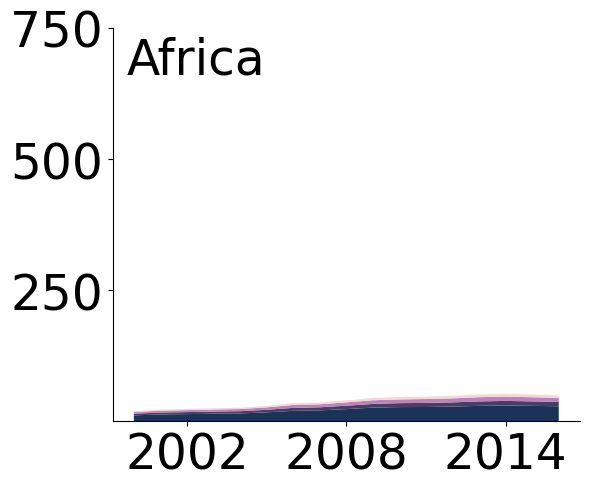

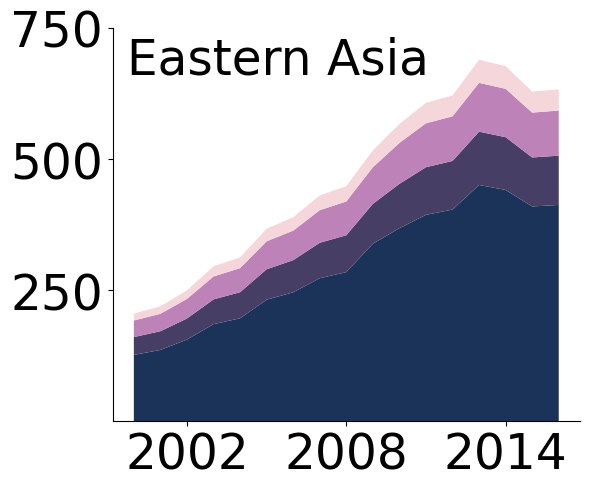

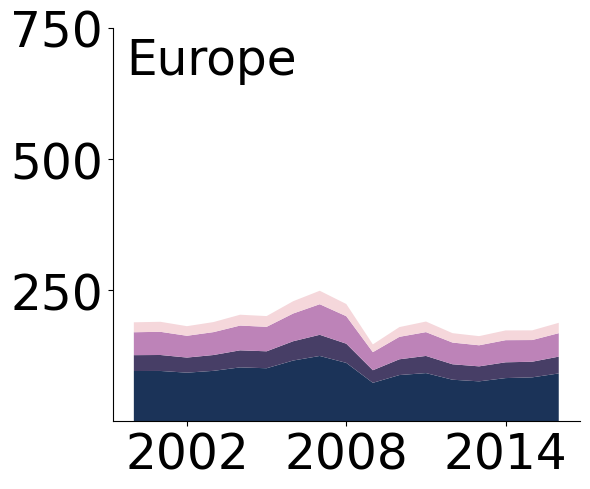

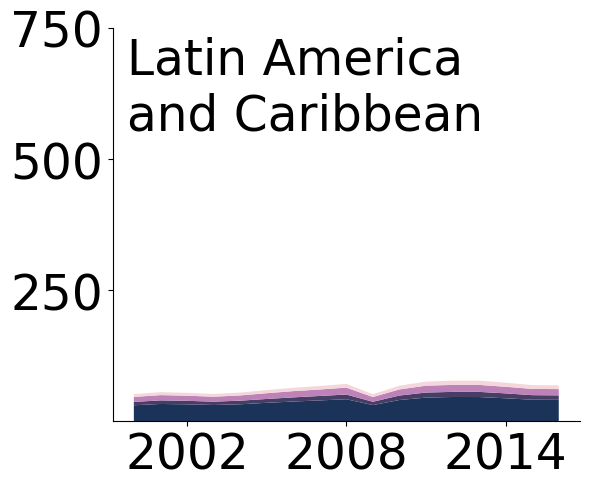

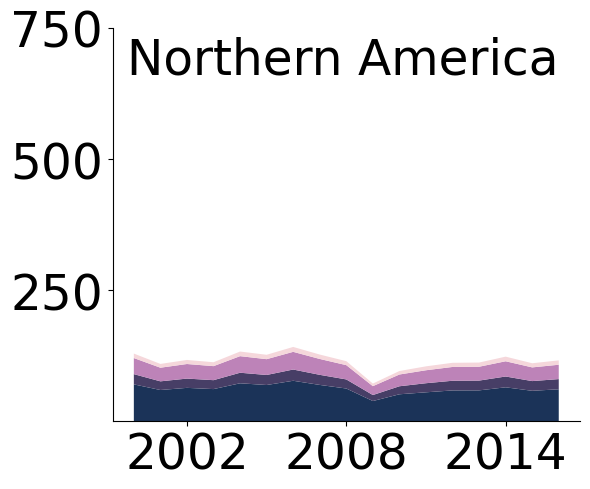

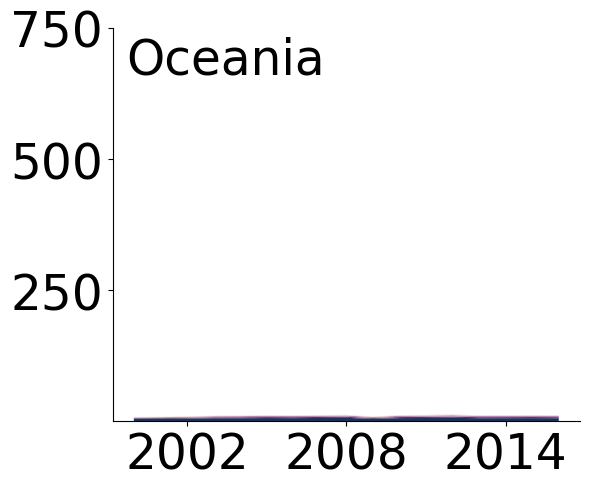

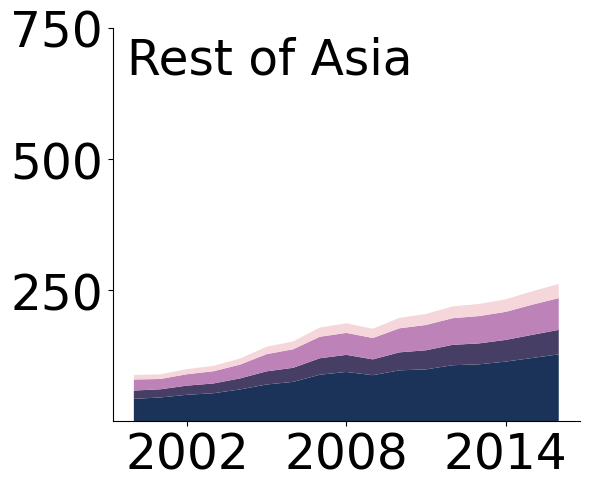

In [74]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter

# Assume df_steel is your DataFrame
regions = df_grouped['Aggregate_Region'].unique()

# Colors for the areas
colors = ['#1B3358', '#473E66', '#BD83B8','#F5D7DB']


# Loop through each region
for region in regions:
    plt.figure(figsize=(6, 5))  # Create a new figure for each plot

    # Filter data for the region
    df_filtered = df_grouped[df_grouped['Aggregate_Region'] == region].drop(columns=["Aggregate_Region"])

    # Group by Year and broader_sector to get total flow per year for each category
    df_smoothed = df_filtered.groupby(["Year", "broader_sector"], as_index=False)["flow"].sum().set_index("Year")

    # Prepare data for plotting
    years = df_smoothed.index.unique()
    build_infra = df_smoothed[df_smoothed["broader_sector"] == "build_infra"]["flow"]
    machinery_stat = df_smoothed[df_smoothed["broader_sector"] == "machinery_stat"]["flow"]
    machinery_trans = df_smoothed[df_smoothed["broader_sector"] == "machinery_trans"]["flow"]
    short_lived_products = df_smoothed[df_smoothed["broader_sector"] == "short_lived_products"]["flow"]

    # Create stack plot
    plt.stackplot(years, build_infra, machinery_stat, machinery_trans, short_lived_products,
                  labels=['build_infra', 'machinery_stat', 'machinery_trans', 'short_lived_products'], colors=colors)



    # Customize the axes and spines
    ax = plt.gca()  # Get current axes
    # ax.set_yscale('log', base=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    
    # Set y-axis limits
    ax.set_ylim(0, 1600)  
    
    if region == "Latin America and Caribbean":
        display_name = "Latin America\nand Caribbean"
    else:
        display_name = region

    ax.text(
        0.03, 0.98, 
        display_name, 
        ha='left', va='top', 
        transform=ax.transAxes, 
        fontsize=35, #fontweight='bold'
    )
    
    ax.set_ylim(0, 700)
    yticks = [250, 500, 750]
    ax.set_yticks(yticks)
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    
    # ax.yaxis.set_major_locator(plt.MaxNLocator(5))  # Adjust the number 5 to your preference
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))  # Adjust the number 5 to your preference

    # Customize the fontsize of x and y-axis tick labels
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontsize(35)  # Set font size
        # label.set_fontweight('bold')  # Set font weight to bold

        
    # Save the figure with a transparent background
    filename = f'gas_{region}_{2000}_{2016}.pdf'
    plt.savefig(plot_path + filename, transparent=True, bbox_inches='tight', dpi=600)

    # Show the plot
    plt.tight_layout()
    plt.show()
    plt.close()  # Close the figure to free up memory


## Background maps

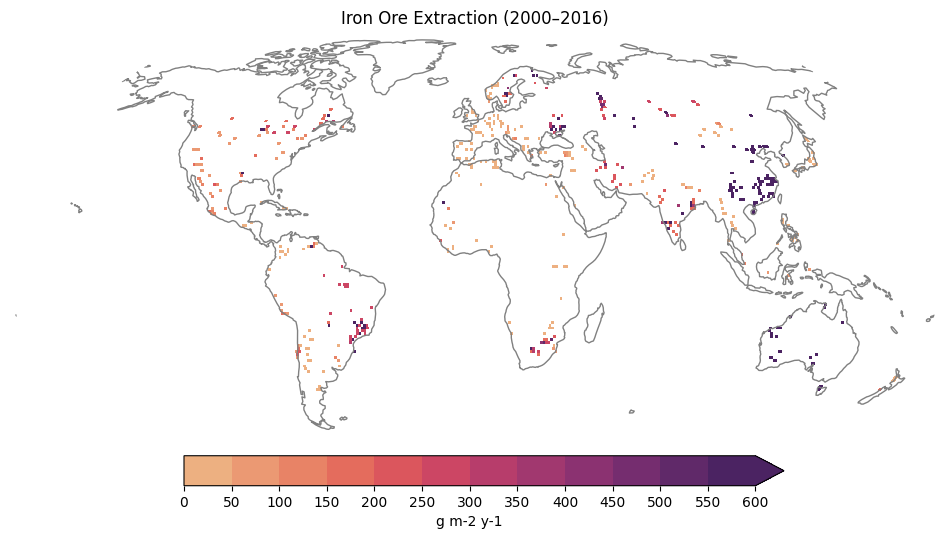

<GeoAxes: title={'center': 'Iron Ore Extraction (2000–2016)'}>

In [3]:
iron_ore_extraction = xr.open_dataset(netcdf_path + "L.iron_ore.2000-2022.a.nc")
iron_ore_extraction = iron_ore_extraction.sel(time=slice('2000-01-01', '2016-01-01'))

# Calculate the average flux over the entire time range (2000–2016)
average_flux = iron_ore_extraction['iron_ore'].fillna(0).mean(dim='time')
average_flux = xr.where(average_flux == 0, np.nan, average_flux)

# Plot the average flux to represent the entire time period as a single picture
ssm.plot_map(
    variable="iron_ore",
    dataset=average_flux.to_dataset(name="iron_ore"),
    color="flare",
    levels=12,
    vmin=0,
    vmax=600,
    extend_max=True,
    label="g m-2 y-1",
    remove_ata=True,
    out_bound=False,
    title="Iron Ore Extraction (2000–2016)",
    output_dir=plot_path, 
    filename="Average_Iron_Ore_Flux_00_16.pdf"
)

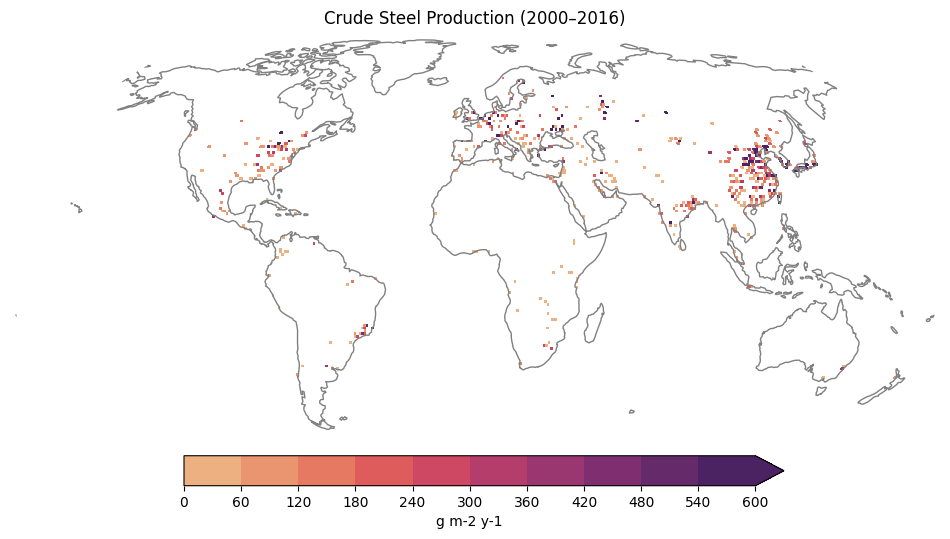

<GeoAxes: title={'center': 'Crude Steel Production (2000–2016)'}>

In [4]:
crude_steel_production = xr.open_dataset(netcdf_path + "T.steel.2000-2022_v3.a.nc")
crude_steel_production = crude_steel_production.sel(time=slice('2000-01-01', '2016-01-01'))

# Calculate the average flux over the entire time range (2000–2016)
average_flux = crude_steel_production['crude_steel'].fillna(0).mean(dim='time')
average_flux = xr.where(average_flux == 0, np.nan, average_flux)

# Plot the average flux to represent the entire time period as a single picture
ssm.plot_map(
    variable="crude_steel",
    dataset=average_flux.to_dataset(name="crude_steel"),
    color="flare",
    vmin=0,
    vmax=600,
    extend_max=True,
    label="g m-2 y-1",
    remove_ata=True,
    out_bound=False,
    title="Crude Steel Production (2000–2016)",
    output_dir=plot_path, 
    filename="Average_Crude_Steel_Flux_00_16.pdf"
)

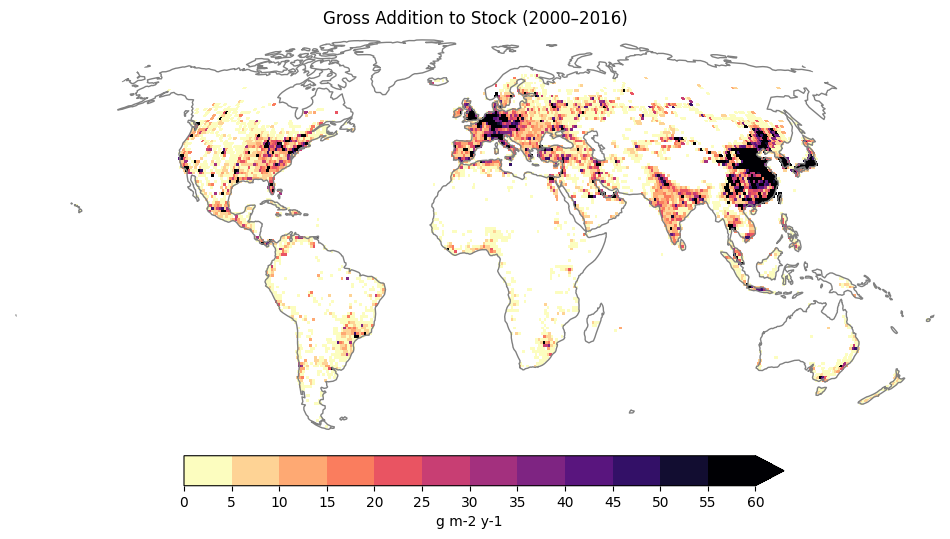

<GeoAxes: title={'center': 'Gross Addition to Stock (2000–2016)'}>

In [5]:
gas = xr.open_dataset(netcdf_path + "T.iron_enduse.gas.2000-2016.a.nc")

# Calculate the average flux over the entire time range (2000–2016)
average_flux = gas['GAS_total'].fillna(0).mean(dim='time')
average_flux = average_flux.where(average_flux > 1, np.nan) 

# Plot the average flux to represent the entire time period as a single picture
ssm.plot_map(
    variable="GAS_total",
    dataset=average_flux.to_dataset(name="GAS_total"),
    color="magma_r",
    levels=12,
    vmin=0,
    vmax=60,
    label="g m-2 y-1",
    extend_max=True,
    out_bound=False,
    remove_ata=True,
    title="Gross Addition to Stock (2000–2016)",
    output_dir=plot_path, 
    filename="Average_GAS_Flux_00_16.pdf"
)

# Figure S2

In [75]:
ds_iron = xr.open_dataset(netcdf_path + "L.iron_ore.2000-2022.a.nc")
ds_steel = xr.open_dataset(netcdf_path + "T.steel.2000-2022.a.nc")
ds_gas = xr.open_dataset(netcdf_path + "T.iron_enduse.gas.2000-2016.a.nc")

In [76]:
def count_cells_for_threshold(ds, variable, years, thresholds=[0.5, 0.75, 0.9]):
    results = {f"{int(thresh*100)}%": [] for thresh in thresholds}

    for year in years:
        data = (ds[variable] * ds["grid_area"]).sel(time=str(year)).sum(dim="time", skipna=True)
        flat_data = data.values.flatten()
        valid_data = flat_data[~np.isnan(flat_data)]
        sorted_vals = np.sort(valid_data)[::-1]
        cumulative = np.cumsum(sorted_vals)
        total = cumulative[-1]

        for thresh in thresholds:
            idx = np.searchsorted(cumulative, thresh * total) + 1  # +1 for 1-based indexing
            results[f"{int(thresh*100)}%"].append(idx)

    return results

In [77]:
(13999 + 14040)/2

14019.5

In [78]:
(14020*100)/(64800*0.3)

72.11934156378601

iron_metal : {'50%': [np.int64(42), np.int64(40), np.int64(40), np.int64(38), np.int64(37), np.int64(36), np.int64(37), np.int64(37), np.int64(36), np.int64(34), np.int64(35), np.int64(36), np.int64(35), np.int64(34), np.int64(30), np.int64(26), np.int64(24), np.int64(24), np.int64(23), np.int64(23), np.int64(21), np.int64(22), np.int64(20)], '75%': [np.int64(120), np.int64(116), np.int64(115), np.int64(111), np.int64(110), np.int64(109), np.int64(111), np.int64(109), np.int64(107), np.int64(102), np.int64(105), np.int64(106), np.int64(109), np.int64(109), np.int64(101), np.int64(92), np.int64(88), np.int64(88), np.int64(82), np.int64(83), np.int64(74), np.int64(75), np.int64(68)]}
crude_steel : {'50%': [np.int64(51), np.int64(52), np.int64(52), np.int64(53), np.int64(55), np.int64(57), np.int64(58), np.int64(58), np.int64(59), np.int64(56), np.int64(57), np.int64(58), np.int64(58), np.int64(56), np.int64(57), np.int64(57), np.int64(58), np.int64(59), np.int64(59), np.int64(57), np.int

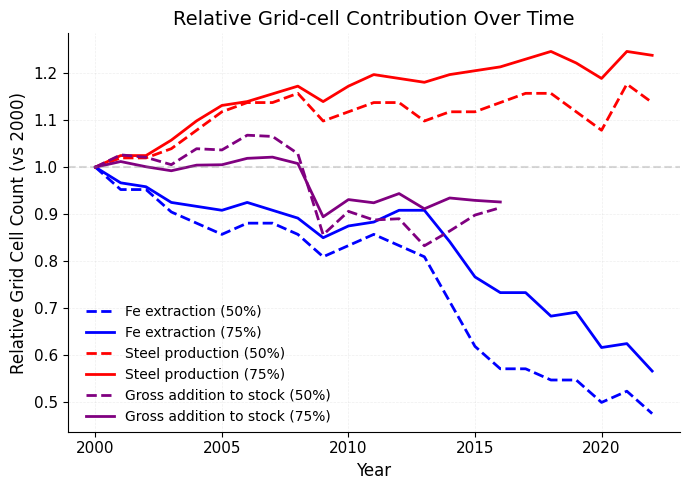

In [79]:
def plot_cell_threshold_relative_styled_multi_fixed_base(
    datasets_vars, thresholds=[0.5, 0.75], base_year=2000
):
    variable_colors = {
        "iron_metal": "blue",   # blue
        "crude_steel": "red",  # red
        "GAS_total": "purple"     # green
    }

    threshold_styles = {
        0.5: "dashed",
        0.75: "solid"
    }

    plt.figure(figsize=(7, 5))

    for ds, var in datasets_vars:
        all_years = ds['time.year'].values
        years = sorted(list(all_years[all_years >= base_year]))

        result = count_cells_for_threshold(ds, var, years, thresholds)
        print(f"{var} : {result}")

        for thresh in thresholds:
            label = f"{int(thresh * 100)}%"
            if base_year not in years:
                print(f"Skipping {var} ({label}) — base year not available.")
                continue
            base_val = result[label][years.index(base_year)]
            rel_vals = [v / base_val for v in result[label]]

            name_map = {
                "iron_metal": "Fe extraction",
                "crude_steel": "Steel production",
                "GAS_total": "Gross addition to stock"
            }

            plt.plot(
                years, rel_vals,
                label=f"{name_map[var]} ({label})",
                color=variable_colors[var],
                linestyle=threshold_styles[thresh],
                linewidth=2
            )

    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Relative Grid Cell Count (vs 2000)", fontsize=12)
    plt.title("Relative Grid-cell Contribution Over Time", fontsize=14)
    plt.axhline(1.0, linestyle='--', color='gray', alpha=0.3)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.grid(alpha=0.2, linestyle='--', linewidth=0.5)
    plt.legend(
    frameon=False,
    fontsize=10,
    loc="upper right",
    bbox_to_anchor=(0.45, 0.35),  # x=centered, y=below the plot
    # ncol=2  # display legend in two columns (optional for compactness)
    )
    plt.tight_layout()

    for spine in ["top", "right"]:
        plt.gca().spines[spine].set_visible(False)
    
    plt.savefig(plot_path + "relative_grid-cell_contribution.pdf", dpi=600)

    plt.show()

datasets_vars = [
    (ds_iron, "iron_metal"),
    (ds_steel, "crude_steel"),
    (ds_gas, "GAS_total")
]

plot_cell_threshold_relative_styled_multi_fixed_base(datasets_vars, thresholds=[0.5, 0.75], base_year=2000)


## Fe relative change map

In [80]:
ds_iron = xr.open_dataset(netcdf_path + "L.iron_ore.2000-2022.a.nc")
ds_iron = ds_iron.fillna(0)
# ds_iron["slope"] = ((ds_iron["iron_metal"].isel(time=-1) - ds_iron["iron_metal"].isel(time=0)) * 100) / ds_iron["iron_metal"].isel(time=0)
years = ds_iron.sizes["time"] - 1
first = ds_iron["iron_metal"].isel(time=0)
last = ds_iron["iron_metal"].isel(time=-1)
slope = ((last - first) / first) * 100 # / years
ds_iron["slope"] = slope.where(first != 0)
# ds_iron["slope"] = xr.where(ds_iron["slope"] == 0, np.nan, ds_iron["slope"])
ds_iron

<xarray.Dataset> Size: 26MB
Dimensions:         (lat: 180, lon: 360, time: 23)
Coordinates:
  * lon             (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat             (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time            (time) datetime64[ns] 184B 2000-01-01 ... 2022-01-01
Data variables:
    iron_ore_mines  (lat, lon) float64 518kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    land_frac       (lat, lon) float64 518kB 0.005732 0.005732 ... 0.0 0.0
    grid_area       (lat, lon) float64 518kB 1.089e+08 1.089e+08 ... 1.089e+08
    iron_metal      (time, lat, lon) float64 12MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    iron_ore        (time, lat, lon) float64 12MB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    slope           (lat, lon) float64 518kB nan nan nan nan ... nan nan nan nan
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0

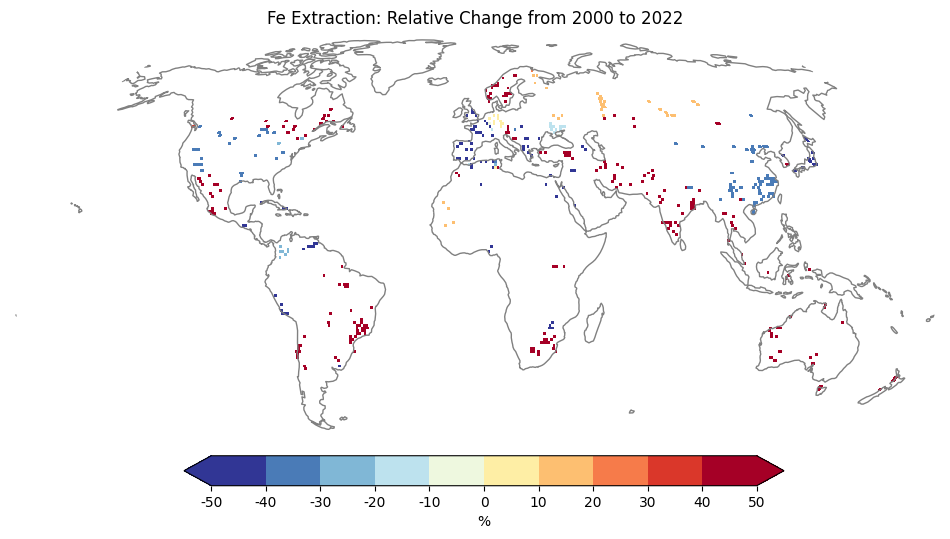

<GeoAxes: title={'center': 'Fe Extraction: Relative Change from 2000 to 2022'}>

In [81]:
# Plot the weighted flux
ssm.plot_map(
    variable="slope", 
    dataset=ds_iron, 
    color="RdYlBu_r",
    vmin=-50,
    vmax=50,
    # levels=12,
    extend_min=True,
    extend_max=True,
    title = "Fe Extraction: Relative Change from 2000 to 2022",
    label= "%",
    remove_ata = True,
    out_bound = False,
    output_dir=plot_path, 
    filename="Fe_ex_relative_change_00_22.pdf"
)

In [82]:
ds_steel = xr.open_dataset(netcdf_path + "T.steel.2000-2022.a.nc")
ds_steel = ds_steel.fillna(0)
years = ds_steel.sizes["time"] - 1
# ds_steel["slope"] = ((ds_steel["crude_steel"].isel(time=-1) - ds_steel["crude_steel"].isel(time=0)) * 100) / ds_steel["crude_steel"].isel(time=0)

years = ds_steel.sizes["time"] - 1
first = ds_steel["crude_steel"].isel(time=0)
last = ds_steel["crude_steel"].isel(time=-1)
slope = ((last - first) / first) * 100 # / years
ds_steel["slope"] = slope.where(first != 0)
# ds_iron["slope"] = xr.where(ds_iron["slope"] ==0, np.nan, ds_iron["slope"])
ds_steel

<xarray.Dataset> Size: 73MB
Dimensions:                    (lat: 180, lon: 360, time: 23)
Coordinates:
  * lon                        (lon) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * lat                        (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * time                       (time) datetime64[ns] 184B 2000-01-01 ... 2022...
Data variables:
    grid_area                  (lat, lon) float64 518kB 1.089e+08 ... 1.089e+08
    land_frac                  (lat, lon) float64 518kB 0.005732 ... 0.0
    crude_steel                (time, lat, lon) float64 12MB 0.0 0.0 ... 0.0 0.0
    crude_steel_from_scrap     (time, lat, lon) float64 12MB 0.0 0.0 ... 0.0 0.0
    crude_steel_from_iron_ore  (time, lat, lon) float64 12MB 0.0 0.0 ... 0.0 0.0
    pre_consumer_scrap         (time, lat, lon) float64 12MB 0.0 0.0 ... 0.0 0.0
    post_consumer_scrap        (time, lat, lon) float64 12MB 0.0 0.0 ... 0.0 0.0
    steel_plants               (time, lat, lon) float64 12MB 0.0 0.0 ... 0.0 0.0
    slope                      (lat, lon) float64 518kB nan nan nan ... nan nan
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0

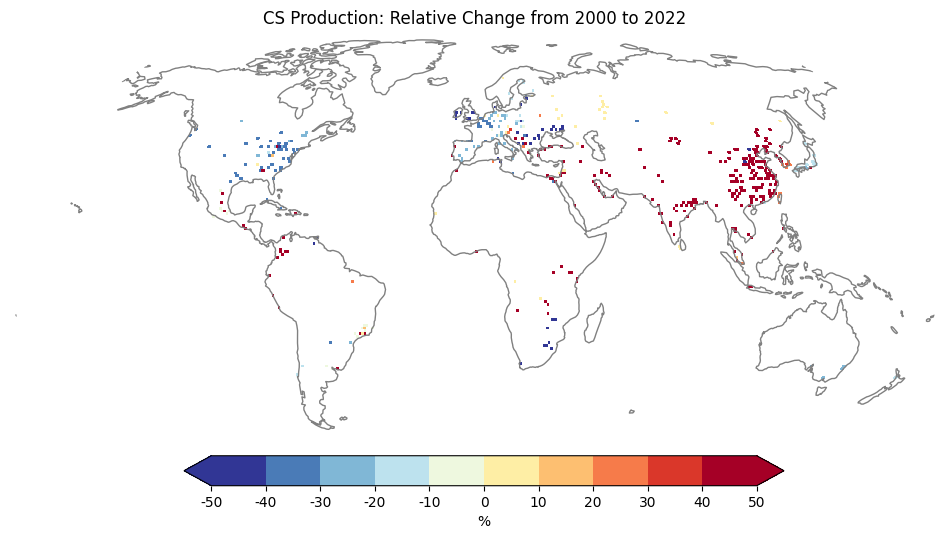

<GeoAxes: title={'center': 'CS Production: Relative Change from 2000 to 2022'}>

In [83]:
# Plot the weighted flux
ssm.plot_map(
    variable="slope", 
    dataset=ds_steel, 
    color="RdYlBu_r",
    vmin=-50,
    vmax=50,
    # levels=12,
    extend_min=True,
    extend_max=True,
    title = "CS Production: Relative Change from 2000 to 2022",
    label= "%",
    remove_ata = True,
    out_bound = False,
    output_dir=plot_path, 
    filename="CS_prod_relative_change_00_22.pdf"
)

In [84]:
ds_gas = xr.open_dataset(netcdf_path + "T.iron_enduse.gas.2000-2016.a.nc")
ds_gas["GAS_total"].mean(dim='time').sum().item() * 0.97

104513.4974633309

In [85]:
ds_gas = xr.open_dataset(netcdf_path + "T.iron_enduse.gas.2000-2016.a.nc")
ds_gas["GAS_total"] = xr.where(ds_gas["GAS_total"] < 1, np.nan, ds_gas["GAS_total"])
ds_gas = ds_gas.fillna(0)
# ds_gas["slope"] = ((ds_gas["GAS_total"].isel(time=-1) - ds_gas["GAS_total"].isel(time=0)) * 100) / ds_gas["GAS_total"].isel(time=0)
years = ds_gas.sizes["time"] - 1
# ds_gas["slope"] = ((ds_gas["GAS_total"].isel(time=-1) - ds_gas["GAS_total"].isel(time=0)) 
#                    / ds_gas["GAS_total"].isel(time=0)) * 100 / years

# first = ds_gas["GAS_total"].sel(time=slice('2000-01-01', '2003-01-01')).mean(dim='time')
# last = ds_gas["GAS_total"].sel(time=slice('2013-01-01', '2016-01-01')).mean(dim='time')
first = ds_gas["GAS_total"].isel(time=0)
last = ds_gas["GAS_total"].isel(time=-1)

slope = ((last - first) / first) * 100 # / years
ds_gas["slope"] = slope.where(first != 0)
# epsilon = 1e-9
# ds_gas["slope"] = ((last - first) / (first + epsilon)) * 100 / years
# ds_gas["slope"] = xr.where(ds_gas["slope"] == 0, np.nan, ds_gas["slope"])
ds_gas

<xarray.Dataset> Size: 125MB
Dimensions:                                     (lat: 180, lon: 360, time: 17)
Coordinates:
  * lon                                         (lon) float64 3kB -179.5 ... ...
  * lat                                         (lat) float64 1kB -89.5 ... 89.5
  * time                                        (time) datetime64[ns] 136B 20...
Data variables: (12/17)
    land_frac                                   (lat, lon) float64 518kB 0.00...
    grid_area                                   (lat, lon) float64 518kB 1.08...
    Civil_engineering_except_roads              (time, lat, lon) float64 9MB ...
    Computers_and_precision_instruments         (time, lat, lon) float64 9MB ...
    Electrical_equipment                        (time, lat, lon) float64 9MB ...
    Food_packaging                              (time, lat, lon) float64 9MB ...
    ...                                          ...
    Other_transport_equipment                   (time, lat, lon) float64 9MB ...
    Printed_matter_and_recorded_media           (time, lat, lon) float64 9MB ...
    Products_nec                                (time, lat, lon) float64 9MB ...
    Residential_buildings                       (time, lat, lon) float64 9MB ...
    Textiles                                    (time, lat, lon) float64 9MB ...
    slope                                       (lat, lon) float64 518kB nan ...
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0

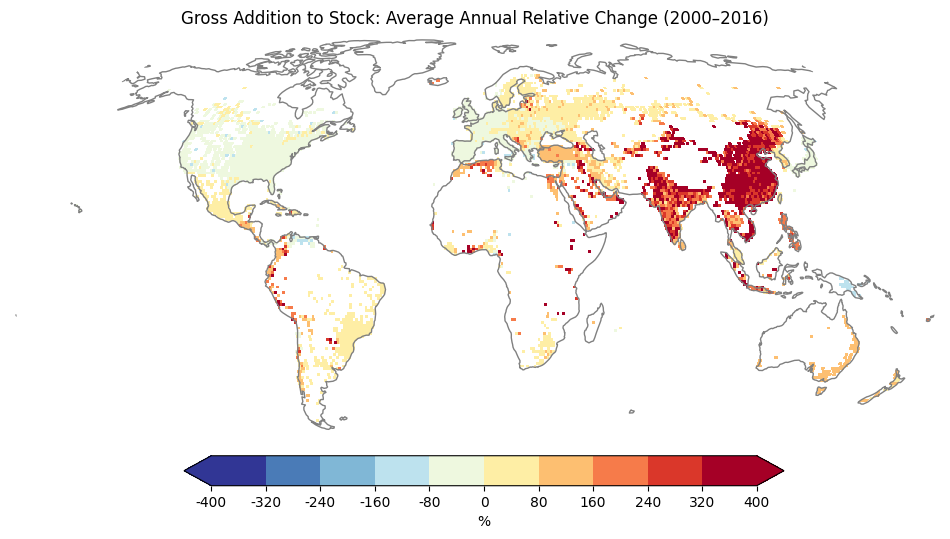

<GeoAxes: title={'center': 'Gross Addition to Stock: Average Annual Relative Change (2000–2016)'}>

In [86]:
# Plot the weighted flux
ssm.plot_map(
    variable="slope", 
    dataset=ds_gas, 
    color="RdYlBu_r",
    vmin=-400,
    vmax=400,
    # levels=[-60 ,-5, 0, 5, 60, 115, 170, 225, 280, 335, 390, 445, 500],
    levels=10,
    extend_min=True,
    extend_max=True,
    title = "Gross Addition to Stock: Average Annual Relative Change (2000–2016)",
    label= "%",
    remove_ata = True,
    out_bound = False,
    output_dir=plot_path, 
    filename="GAS_relative_change_00_16.pdf"
)

# Figure 2

In [87]:
iron_ore_extraction = xr.open_dataset(netcdf_path + "L.iron_ore.2000-2022.a.nc").sel(time=slice('2000-01-01', '2016-01-01'))
iron_ore_extraction = iron_ore_extraction[["iron_ore", "iron_metal", "grid_area"]]
iron_ore_extraction

<xarray.Dataset> Size: 18MB
Dimensions:     (time: 17, lat: 180, lon: 360)
Coordinates:
  * lon         (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat         (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time        (time) datetime64[ns] 136B 2000-01-01 2001-01-01 ... 2016-01-01
Data variables:
    iron_ore    (time, lat, lon) float64 9MB ...
    iron_metal  (time, lat, lon) float64 9MB ...
    grid_area   (lat, lon) float64 518kB ...
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0

In [88]:
end_use_stocks = xr.open_dataset(netcdf_path + "T.iron_enduse.2000-2016.a.nc")
end_use_stocks = end_use_stocks[["stock_total"]]
# Calculate yearly flux (g m-2 y-1)
end_use_flux = end_use_stocks.diff(dim='time')  # Difference between years

# Align the time dimension (optional, to match the midpoints between years)
end_use_flux['time'] = end_use_stocks['time'].isel(time=slice(1, None))
# Assign the flux units
end_use_flux.attrs['units'] = 'g m-2 y-1'
# Save or inspect the result
end_use_flux

<xarray.Dataset> Size: 8MB
Dimensions:      (time: 16, lat: 180, lon: 360)
Coordinates:
  * lon          (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat          (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time         (time) datetime64[ns] 128B 2001-01-01 2002-01-01 ... 2016-01-01
Data variables:
    stock_total  (time, lat, lon) float64 8MB nan nan nan nan ... nan nan nan
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0
    units:           g m-2 y-1

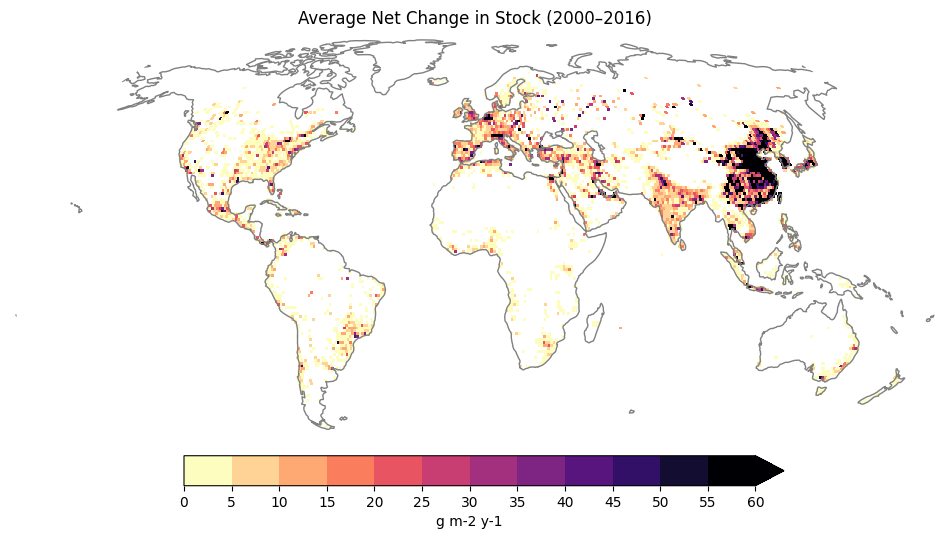

<GeoAxes: title={'center': 'Average Net Change in Stock (2000–2016)'}>

In [89]:
# Calculate the average flux over the entire time range (2000–2016)
average_flux = end_use_flux['stock_total'].mean(dim='time')
average_flux = average_flux.where(average_flux > 1, np.nan) 

# Plot the average flux to represent the entire time period as a single picture
ssm.plot_map(
    variable="stock_total",
    dataset=average_flux.to_dataset(name="stock_total"),
    color="magma_r",
    levels=12,
    vmin=0,
    vmax=60,
    label="g m-2 y-1",
    extend_max=True,
    out_bound=False,
    remove_ata=True,
    title="Average Net Change in Stock (2000–2016)",
    output_dir=plot_path, 
    filename="Stock_Flux_00_16.pdf"
)

In [90]:
# Calculate the average flux over the entire time range (2000–2016)
average_flux = end_use_flux['stock_total'].mean(dim='time')
(average_flux * iron_ore_extraction["grid_area"] * 1e-12).sum().item()

694.6812275908635

In [92]:
iron_ore_extraction = xr.open_dataset(netcdf_path + "L.iron_ore.2000-2022.a.nc")
iron_ore_extraction = iron_ore_extraction.sel(time=slice('2000-01-01', '2016-01-01'))
crude_steel_production = xr.open_dataset(netcdf_path + "T.steel.2000-2022.a.nc")
crude_steel_production = crude_steel_production.sel(time=slice('2000-01-01', '2016-01-01'))

In [93]:
thres = 1
# Calculate the average flux over the entire time range for each component
extraction_flux = iron_ore_extraction['iron_metal'].mean(dim='time')  # Iron content flux
production_flux = crude_steel_production['crude_steel'].mean(dim='time')  # Crude steel production flux
# Assuming the average iron (Fe) content in steel globally is roughly 97%, with the remaining 2-3% consisting of carbon and other trace elements.
enduse_flux =(end_use_flux['stock_total'] * 0.97).mean(dim='time')
# enduse_flux = enduse_flux.where(enduse_flux > thres, np.nan)

# Calculate the net flow
net_flux = extraction_flux.fillna(0) - enduse_flux.fillna(0)
net_flux = net_flux.where(net_flux != 0, np.nan)

net_flux_ds = net_flux.to_dataset(name='net_flux')
# Assign units and attributes to the net flux for clarity
net_flux_ds.attrs['long_name'] = 'Net Iron Flow: (Extraction - End-Use)'
net_flux_ds.attrs['units'] = 'gFe m-2 y-1'
net_flux_ds = xr.merge([net_flux_ds, iron_ore_extraction[["grid_area"]]])
net_flux_ds

<xarray.Dataset> Size: 1MB
Dimensions:    (lon: 360, lat: 180)
Coordinates:
  * lon        (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat        (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    net_flux   (lat, lon) float64 518kB nan nan nan nan nan ... nan nan nan nan
    grid_area  (lat, lon) float64 518kB ...
Attributes:
    long_name:  Net Iron Flow: (Extraction - End-Use)
    units:      gFe m-2 y-1

In [96]:
thres = 1
# Calculate the average flux over the entire time range for each component
extraction_flux = iron_ore_extraction['iron_metal'].mean(dim='time')  # Iron content flux
production_flux = crude_steel_production['crude_steel'].mean(dim='time')  # Crude steel production flux
# Assuming the average iron (Fe) content in steel globally is roughly 97%, with the remaining 2-3% consisting of carbon and other trace elements.
enduse_flux =(end_use_flux['stock_total'] * 0.97).mean(dim='time')
enduse_flux = enduse_flux.where(enduse_flux > thres, np.nan) 

# Calculate the net flow
net_flux = extraction_flux.fillna(0) - enduse_flux.fillna(0)
net_flux = net_flux.where(net_flux != 0, np.nan)

net_flux_ds = net_flux.to_dataset(name='net_flux')
# Assign units and attributes to the net flux for clarity
net_flux_ds.attrs['long_name'] = 'Net Iron Flow: (Extraction - End-Use)'
net_flux_ds.attrs['units'] = 'gFe m-2 y-1'
net_flux_ds

<xarray.Dataset> Size: 523kB
Dimensions:   (lon: 360, lat: 180)
Coordinates:
  * lon       (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    net_flux  (lat, lon) float64 518kB nan nan nan nan nan ... nan nan nan nan
Attributes:
    long_name:  Net Iron Flow: (Extraction - End-Use)
    units:      gFe m-2 y-1

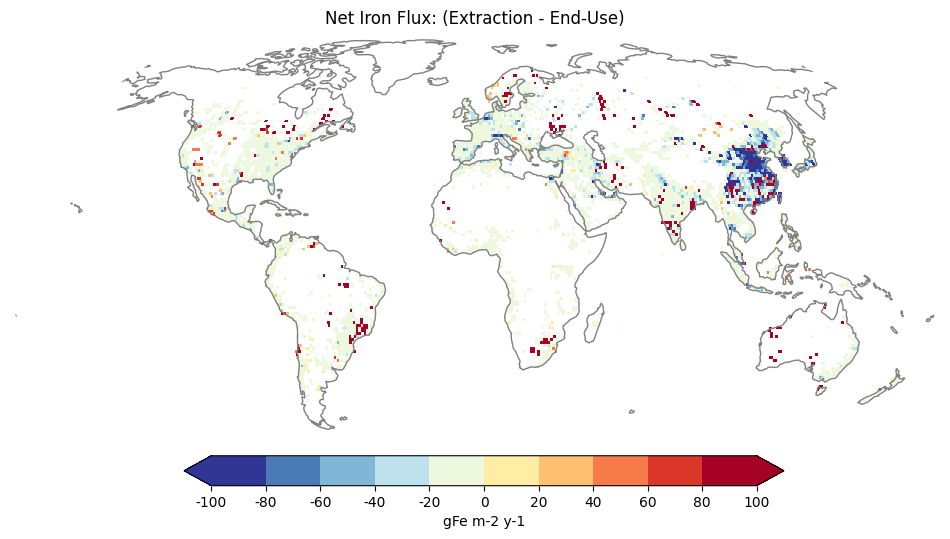

<GeoAxes: title={'center': 'Net Iron Flux: (Extraction - End-Use)'}>

In [97]:
ssm.plot_map(dataset=net_flux_ds,
            variable="net_flux", 
            color="RdYlBu_r", 
            vmin=-100, 
            vmax=100,
            extend_min=True,
            extend_max=True, 
            title= 'Net Iron Flux: (Extraction - End-Use)', 
            label='gFe m-2 y-1', 
            levels=10,
            out_bound=False,
            remove_ata=True, 
            output_dir=plot_path, 
            filename="Net_Fe_Flux_ex_2_end.pdf"
            )    

In [99]:
iron_ore_extraction = xr.open_dataset(netcdf_path + "L.iron_ore.2000-2022.a.nc")
iron_ore_extraction = iron_ore_extraction.sel(time=slice('2000-01-01', '2016-01-01'))
crude_steel_production = xr.open_dataset(netcdf_path + "T.steel.2000-2022.a.nc")
crude_steel_production = crude_steel_production.sel(time=slice('2000-01-01', '2016-01-01'))

In [100]:
end_use_stocks = xr.open_dataset(netcdf_path + "T.iron_enduse.2000-2016.a.nc")
end_use_stocks = end_use_stocks[["stock_total"]]
# Calculate yearly flux (g m-2 y-1)
end_use_flux = end_use_stocks.diff(dim='time')  # Difference between years

# Align the time dimension (optional, to match the midpoints between years)
end_use_flux['time'] = end_use_stocks['time'].isel(time=slice(1, None))
# Assign the flux units
end_use_flux.attrs['units'] = 'g m-2 y-1'
# Save or inspect the result
end_use_flux

<xarray.Dataset> Size: 8MB
Dimensions:      (time: 16, lat: 180, lon: 360)
Coordinates:
  * lon          (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat          (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * time         (time) datetime64[ns] 128B 2001-01-01 2002-01-01 ... 2016-01-01
Data variables:
    stock_total  (time, lat, lon) float64 8MB nan nan nan nan ... nan nan nan
Attributes:
    Project:         Surface Earth System Analysis and Modeling Environment (...
    Research Group:  Integrated Earth System Dynamics
    Institution:     McGill University
    Contact:         eric.galbraith@mcgill.ca
    Data Version:    V1.0
    units:           g m-2 y-1

In [101]:
thres = 1
# Calculate the average flux over the entire time range for each component
extraction_flux = iron_ore_extraction['iron_metal'].mean(dim='time')  # Iron content flux
production_flux = crude_steel_production['crude_steel'].mean(dim='time')  # Crude steel production flux
# Assuming the average iron (Fe) content in steel globally is roughly 97%, with the remaining 2-3% consisting of carbon and other trace elements.
enduse_flux =(end_use_flux['stock_total'] * 0.97).mean(dim='time')
# enduse_flux = enduse_flux.where(enduse_flux > thres, np.nan)

# Calculate the net flow
net_flux = extraction_flux.fillna(0) - enduse_flux.fillna(0)
net_flux = net_flux.where(net_flux != 0, np.nan)

net_flux_ds = net_flux.to_dataset(name='net_flux')
# Assign units and attributes to the net flux for clarity
net_flux_ds.attrs['long_name'] = 'Net Iron Flow: (Extraction - End-Use)'
net_flux_ds.attrs['units'] = 'gFe m-2 y-1'
net_flux_ds = xr.merge([net_flux_ds, iron_ore_extraction[["grid_area"]]])
net_flux_ds

<xarray.Dataset> Size: 1MB
Dimensions:    (lon: 360, lat: 180)
Coordinates:
  * lon        (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * lat        (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables:
    net_flux   (lat, lon) float64 518kB nan nan nan nan nan ... nan nan nan nan
    grid_area  (lat, lon) float64 518kB ...
Attributes:
    long_name:  Net Iron Flow: (Extraction - End-Use)
    units:      gFe m-2 y-1

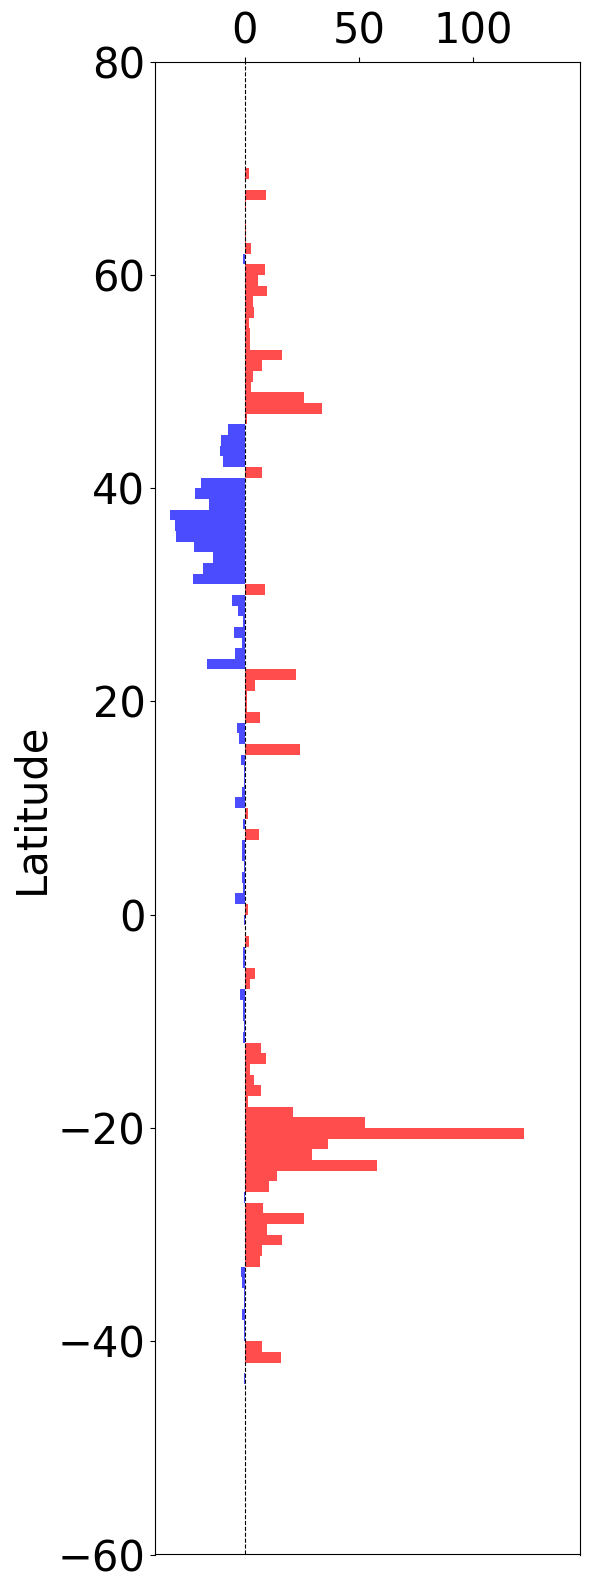

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

net_flux_da = net_flux_ds["net_flux"] * net_flux_ds["grid_area"] * 1e-12

# Aggregate data by latitude (sum over longitude)
net_flux_lat_sum = net_flux_da.sum(dim='lon')

# Extract latitude and values
latitudes = net_flux_lat_sum['lat'].values
values = net_flux_lat_sum.values

# Create 5-degree latitude bins
bar_width = 1
lat_bins = np.arange(-90, 91, bar_width)
lat_centers = (lat_bins[:-1] + lat_bins[1:]) / 2

# Initialize arrays for positive and negative sums
positive_sums = np.zeros(len(lat_centers))
negative_sums = np.zeros(len(lat_centers))

# Calculate sums for each bin
for i in range(len(lat_bins) - 1):
    mask = (latitudes >= lat_bins[i]) & (latitudes < lat_bins[i + 1])
    if mask.any():
        bin_values = values[mask]
        positive_sums[i] = bin_values[bin_values > 0].sum()
        negative_sums[i] = bin_values[bin_values < 0].sum()

# Create the bar chart
fig, ax = plt.subplots(figsize=(6, 16))

# Plot positive and negative bars
ax.barh(lat_centers, positive_sums, height=bar_width, color='red', alpha=0.7, label='Positive Flux')
ax.barh(lat_centers, negative_sums, height=bar_width, color='blue', alpha=0.7, label='Negative Flux')

# Adjust spines (move x-axis to the top)
ax.spines['top'].set_position(('outward', 0))
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(True)

ax.xaxis.set_ticks_position('top')  # move x-axis to top
ax.yaxis.set_ticks_position('left')

ax.xaxis.set_major_locator(plt.MaxNLocator(4))

# Customize the fontsize of axis tick labels
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontsize(30)
    # label.set_fontweight('bold')

# Set limits and grid
ax.set_ylim(-60, 80)
ax.set_xlim(min(negative_sums.min(), 0) * 1.2, max(positive_sums.max(), 0) * 1.2)

ax.axvline(0, color='black', linewidth=0.8, linestyle='--')  # Reference line at 0

# Set tick parameters and labels
ax.tick_params(axis='both', labelsize=30)
ax.set_ylabel('Latitude', fontsize=30)
# ax.set_xlabel('Net Flux Sum (units)', fontsize=20, fontweight='bold')

# # Add legend
# ax.legend(loc='upper right', fontsize=16)

plt.tight_layout()

# Save the figure with a transparent background
filename = f'lat_net_flux_bar_chart.pdf'
plt.savefig(plot_path + filename, transparent=True, bbox_inches='tight', dpi=600)

plt.show()

# Center of Gravity

In [103]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Load dataset
ds_iron = xr.open_dataset(netcdf_path + "L.iron_ore.2000-2022.a.nc")  # use your full path
iron_ore = ds_iron["iron_metal"] * ds_iron["grid_area"] * 1e-12
lat = ds_iron["lat"]
lon = ds_iron["lon"]
time = ds_iron["time"]

# Calculate center of gravity (COG) for each time step
cog_results = []

for t in range(len(time)):
    data = iron_ore.isel(time=t).values
    lat_grid, lon_grid = np.meshgrid(lat, lon, indexing="ij")
    
    weights = np.nan_to_num(data)
    total_weight = weights.sum()

    if total_weight == 0:
        cog_lat = np.nan
        cog_lon = np.nan
    else:
        cog_lat = (lat_grid * weights).sum() / total_weight
        cog_lon = (lon_grid * weights).sum() / total_weight

    cog_results.append({
        "time": pd.to_datetime(time[t].values),
        "lat": cog_lat,
        "lon": cog_lon
    })

# Convert to DataFrame
df_cog = pd.DataFrame(cog_results)
df_cog

time        lat        lon
0  2000-01-01  11.759688  31.008066
1  2001-01-01  10.360520  36.393709
2  2002-01-01  10.470645  36.464848
3  2003-01-01   9.260649  36.174191
4  2004-01-01   9.116428  37.881534
5  2005-01-01   8.752924  40.959880
6  2006-01-01   9.224129  41.980807
7  2007-01-01   9.785471  46.473592
8  2008-01-01   9.268685  48.850516
9  2009-01-01   8.221559  54.909344
10 2010-01-01   7.492977  52.202933
11 2011-01-01   7.384530  49.757178
12 2012-01-01   6.499522  53.192000
13 2013-01-01   6.191035  60.643970
14 2014-01-01   3.314869  58.477203
15 2015-01-01   1.460713  60.239514
16 2016-01-01   1.202197  62.798382
17 2017-01-01   0.613356  61.062018
18 2018-01-01  -0.726358  58.720761
19 2019-01-01  -0.542379  58.871951
20 2020-01-01  -0.502662  58.248630
21 2021-01-01  -0.612263  55.975137
22 2022-01-01  -1.553854  58.770571

In [104]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Load dataset
ds_steel = xr.open_dataset(netcdf_path + "T.steel.2000-2022.a.nc") # use your full path
steel = ds_steel["crude_steel"] * ds_steel["grid_area"] * 1e-12
lat = ds_steel["lat"]
lon = ds_steel["lon"]
time = ds_steel["time"]

# Calculate center of gravity (COG) for each time step
cog_results = []

for t in range(len(time)):
    data = iron_ore.isel(time=t).values
    lat_grid, lon_grid = np.meshgrid(lat, lon, indexing="ij")
    
    weights = np.nan_to_num(data)
    total_weight = weights.sum()

    if total_weight == 0:
        cog_lat = np.nan
        cog_lon = np.nan
    else:
        cog_lat = (lat_grid * weights).sum() / total_weight
        cog_lon = (lon_grid * weights).sum() / total_weight

    cog_results.append({
        "time": pd.to_datetime(time[t].values),
        "lat": cog_lat,
        "lon": cog_lon
    })

# Convert to DataFrame
df_cog = pd.DataFrame(cog_results)
df_cog

time        lat        lon
0  2000-01-01  11.759688  31.008066
1  2001-01-01  10.360520  36.393709
2  2002-01-01  10.470645  36.464848
3  2003-01-01   9.260649  36.174191
4  2004-01-01   9.116428  37.881534
5  2005-01-01   8.752924  40.959880
6  2006-01-01   9.224129  41.980807
7  2007-01-01   9.785471  46.473592
8  2008-01-01   9.268685  48.850516
9  2009-01-01   8.221559  54.909344
10 2010-01-01   7.492977  52.202933
11 2011-01-01   7.384530  49.757178
12 2012-01-01   6.499522  53.192000
13 2013-01-01   6.191035  60.643970
14 2014-01-01   3.314869  58.477203
15 2015-01-01   1.460713  60.239514
16 2016-01-01   1.202197  62.798382
17 2017-01-01   0.613356  61.062018
18 2018-01-01  -0.726358  58.720761
19 2019-01-01  -0.542379  58.871951
20 2020-01-01  -0.502662  58.248630
21 2021-01-01  -0.612263  55.975137
22 2022-01-01  -1.553854  58.770571

Iron Ore COG:
        time        lat        lon
0 2000-01-01  11.759688  31.008066
1 2001-01-01  10.360520  36.393709
2 2002-01-01  10.470645  36.464848
3 2003-01-01   9.260649  36.174191
4 2004-01-01   9.116428  37.881534

Crude Steel COG:
        time        lat        lon
0 2000-01-01  35.806603  41.832636
1 2001-01-01  35.713007  46.369385
2 2002-01-01  35.361321  48.874584
3 2003-01-01  35.171341  51.388832
4 2004-01-01  35.159223  53.643247

Gross Addition to Stock COG:
        time        lat        lon
0 2000-01-01  33.907005  29.422230
1 2001-01-01  33.375762  33.859278
2 2002-01-01  33.001936  36.951302
3 2003-01-01  33.185931  42.723057
4 2004-01-01  33.123682  40.899606


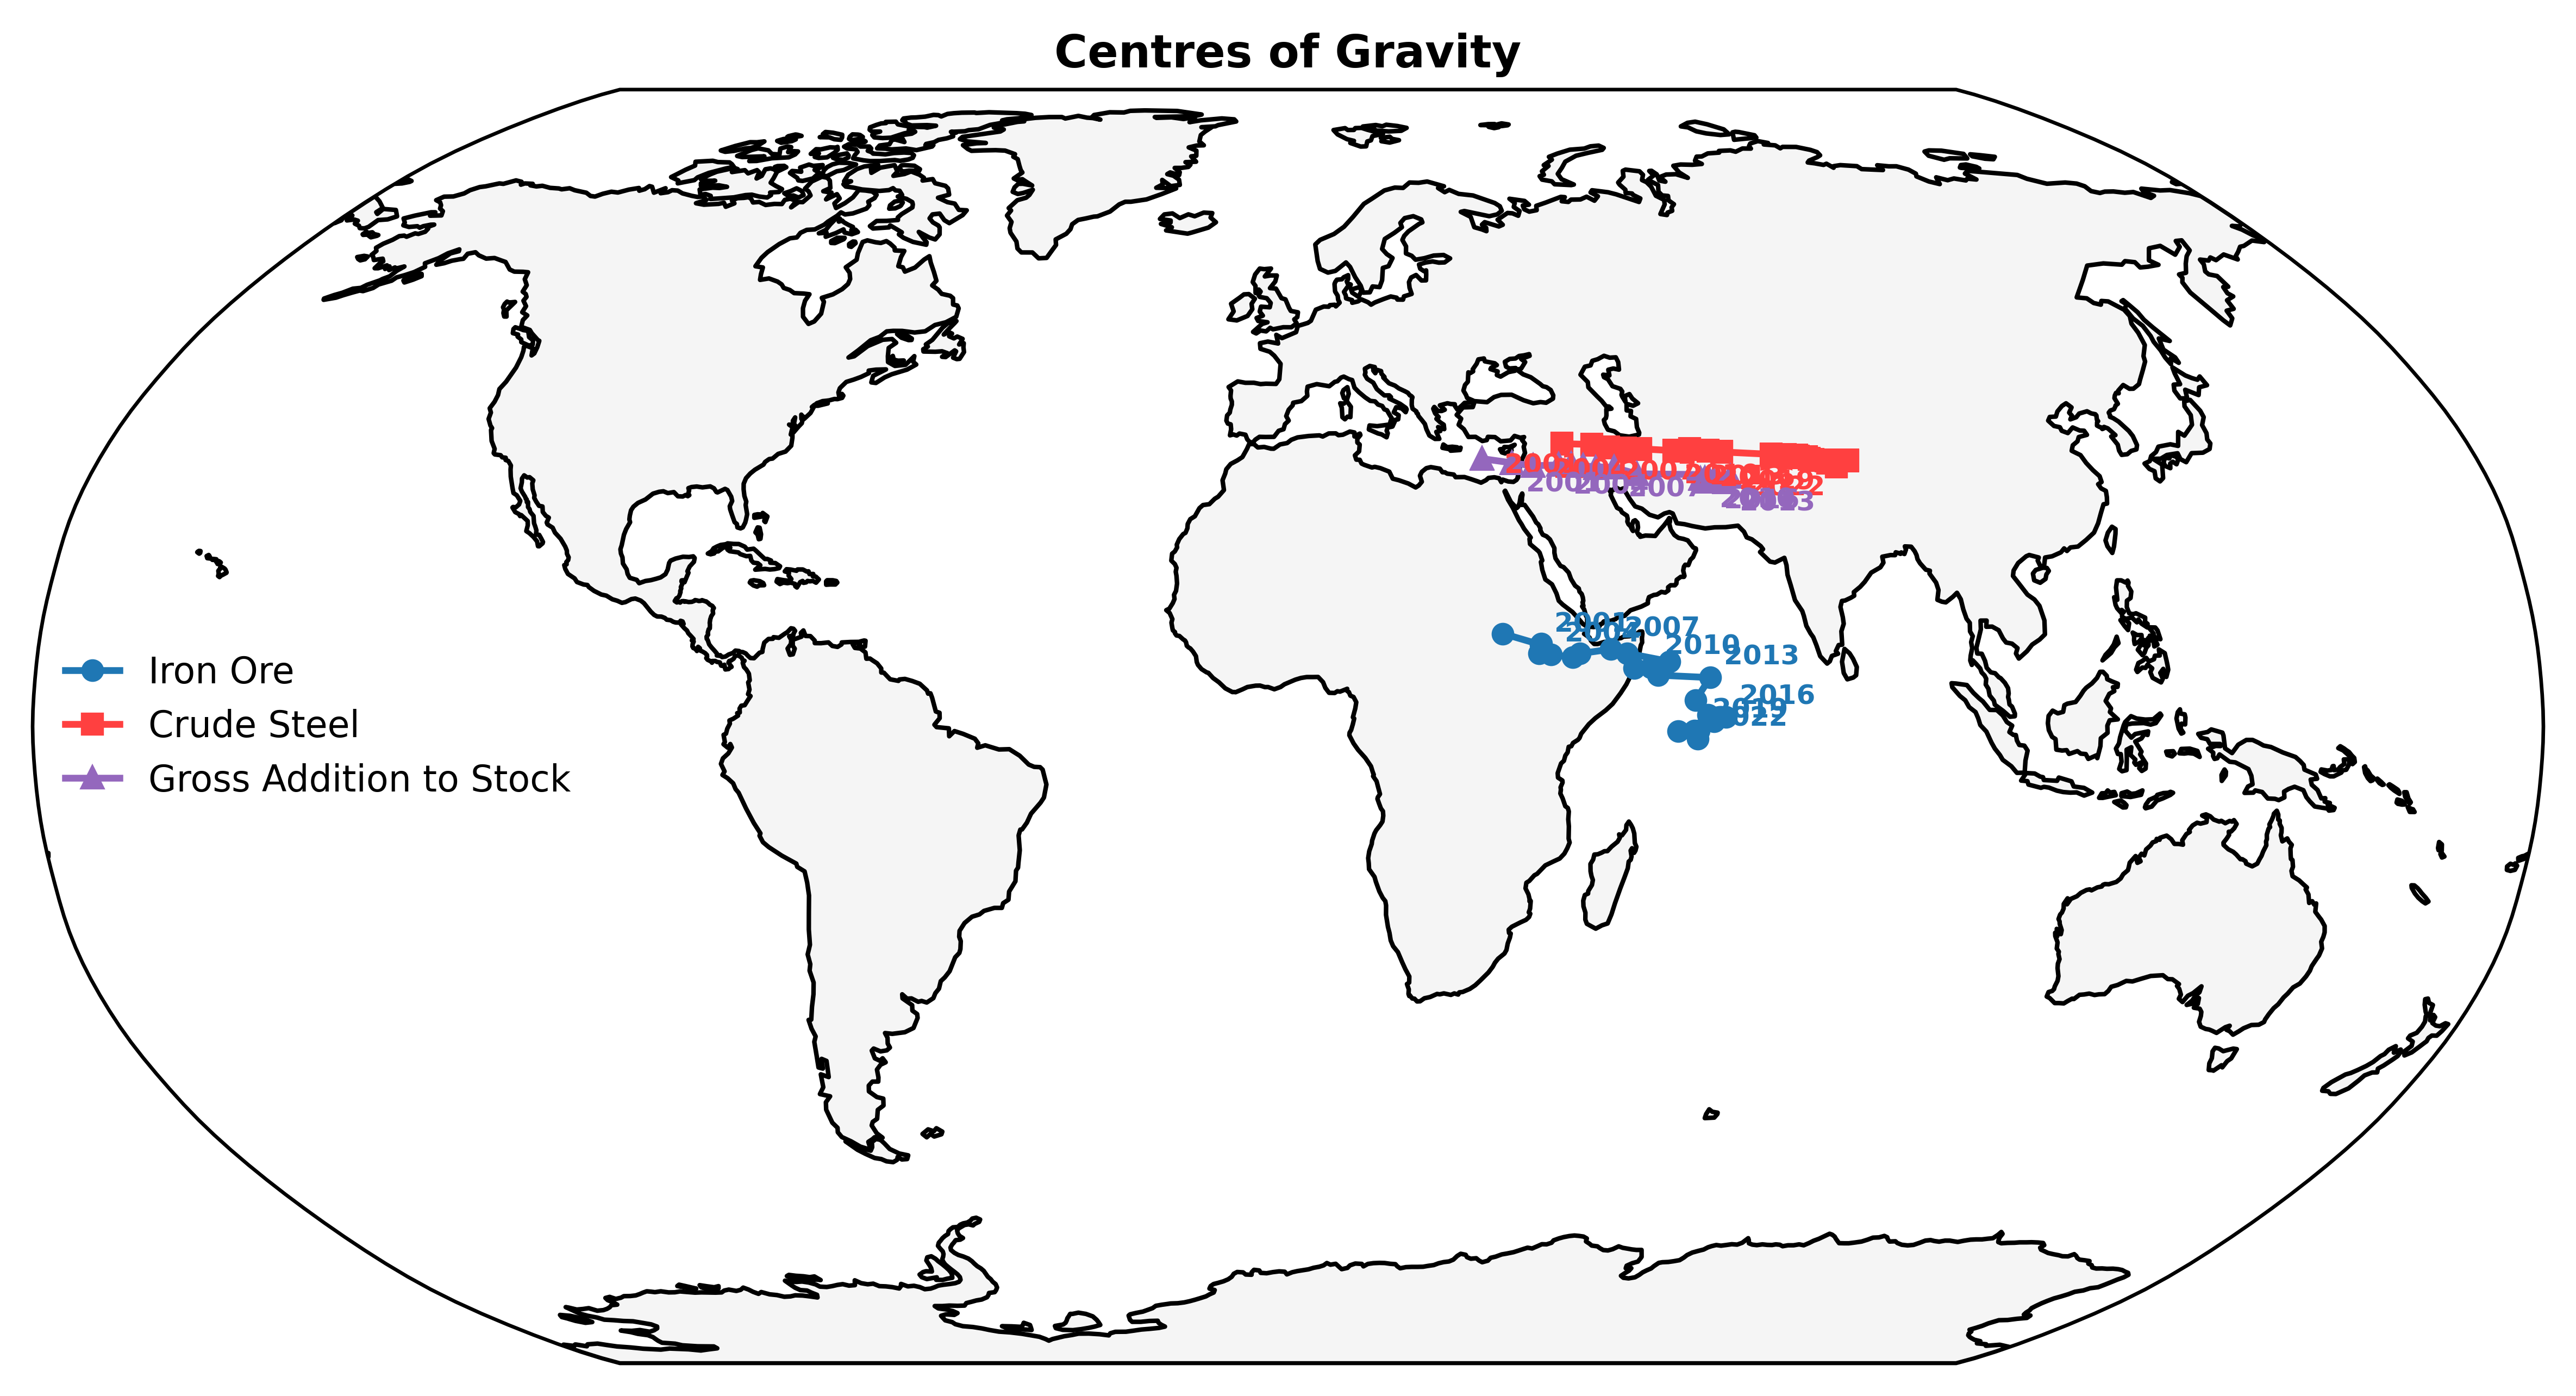

In [105]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load datasets (replace netcdf_path with your full path)
ds_iron = xr.open_dataset(netcdf_path + "L.iron_ore.2000-2022.a.nc")
ds_steel = xr.open_dataset(netcdf_path + "T.steel.2000-2022.a.nc")
ds_gas = xr.open_dataset(netcdf_path + "T.iron_enduse.gas.2000-2016.a.nc")

# Process iron ore data
iron_ore = ds_iron["iron_metal"] * ds_iron["grid_area"] * 1e-12
lat = ds_iron["lat"]
lon = ds_iron["lon"]
time_iron = ds_iron["time"]

# Process crude steel data
steel = ds_steel["crude_steel"] * ds_steel["grid_area"] * 1e-12

# Process gross addition to stock data
gross_addition_to_stock = ds_gas["GAS_total"] * ds_gas["grid_area"] * 1e-12
time_gas = ds_gas["time"]

# Calculate center of gravity (COG) for iron ore
cog_iron_results = []
for t in range(len(time_iron)):
    data = iron_ore.isel(time=t).values
    lat_grid, lon_grid = np.meshgrid(lat, lon, indexing="ij")
    
    weights = np.nan_to_num(data)
    total_weight = weights.sum()

    if total_weight == 0:
        cog_lat = np.nan
        cog_lon = np.nan
    else:
        cog_lat = (lat_grid * weights).sum() / total_weight
        cog_lon = (lon_grid * weights).sum() / total_weight

    cog_iron_results.append({
        "time": pd.to_datetime(time_iron[t].values),
        "lat": cog_lat,
        "lon": cog_lon
    })

df_cog_iron = pd.DataFrame(cog_iron_results)

# Calculate center of gravity (COG) for crude steel
cog_steel_results = []
for t in range(len(time_iron)):
    data = steel.isel(time=t).values
    lat_grid, lon_grid = np.meshgrid(lat, lon, indexing="ij")
    
    weights = np.nan_to_num(data)
    total_weight = weights.sum()

    if total_weight == 0:
        cog_lat = np.nan
        cog_lon = np.nan
    else:
        cog_lat = (lat_grid * weights).sum() / total_weight
        cog_lon = (lon_grid * weights).sum() / total_weight

    cog_steel_results.append({
        "time": pd.to_datetime(time_iron[t].values),
        "lat": cog_lat,
        "lon": cog_lon
    })

df_cog_steel = pd.DataFrame(cog_steel_results)

# Calculate center of gravity (COG) for gross addition to stock
cog_gas_results = []
for t in range(len(time_gas)):
    data = gross_addition_to_stock.isel(time=t).values
    lat_grid, lon_grid = np.meshgrid(lat, lon, indexing="ij")  # Assuming same grid
    
    weights = np.nan_to_num(data)
    total_weight = weights.sum()

    if total_weight == 0:
        cog_lat = np.nan
        cog_lon = np.nan
    else:
        cog_lat = (lat_grid * weights).sum() / total_weight
        cog_lon = (lon_grid * weights).sum() / total_weight

    cog_gas_results.append({
        "time": pd.to_datetime(time_gas[t].values),
        "lat": cog_lat,
        "lon": cog_lon
    })

df_cog_gas = pd.DataFrame(cog_gas_results)

# Display DataFrames
print("Iron Ore COG:")
print(df_cog_iron.head())
print("\nCrude Steel COG:")
print(df_cog_steel.head())
print("\nGross Addition to Stock COG:")
print(df_cog_gas.head())

# Plot with Nature-style formatting
plt.figure(figsize=(8, 6), dpi=600)  # High resolution for publication
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='#F5F5F5')  # Light gray background
ax.coastlines(linewidth=0.5)

# Iron ore path (blue, circle)
ax.plot(df_cog_iron["lon"], df_cog_iron["lat"], transform=ccrs.Geodetic(), 
        color='#1F77B4', linewidth=1.5, marker='o', markersize=4, label='Iron Ore', zorder=2)

# Crude steel path (red, square)
ax.plot(df_cog_steel["lon"], df_cog_steel["lat"], transform=ccrs.Geodetic(), 
        color='#FF4040', linewidth=1.5, marker='s', markersize=4, label='Crude Steel', zorder=2)

# Gross addition to stock path (green, triangle)
ax.plot(df_cog_gas["lon"], df_cog_gas["lat"], transform=ccrs.Geodetic(), 
        color='#9467BD', linewidth=1.5, marker='^', markersize=4, label='Gross Addition to Stock', zorder=2)

# Add year labels every 3 years with offset to avoid overlap
for _, row in df_cog_iron.iterrows():
    if row["time"].year % 3 == 0:
        ax.text(row["lon"] + 2, row["lat"] + 1, str(row["time"].year), 
                fontsize=6, transform=ccrs.Geodetic(), color='#1F77B4', 
                ha='left', va='bottom', fontweight='bold')

for _, row in df_cog_steel.iterrows():
    if row["time"].year % 3 == 0:
        ax.text(row["lon"] - 2, row["lat"] - 1, str(row["time"].year), 
                fontsize=6, transform=ccrs.Geodetic(), color='#FF4040', 
                ha='right', va='top', fontweight='bold')

for _, row in df_cog_gas.iterrows():
    if row["time"].year % 3 == 0 and row["time"].year <= 2016:  # Limit to 2000–2016
        ax.text(row["lon"] + 2, row["lat"] - 1, str(row["time"].year), 
                fontsize=6, transform=ccrs.Geodetic(), color='#9467BD', 
                ha='left', va='top', fontweight='bold')

# Legend and title
ax.legend(loc='center left', frameon=False, fontsize=8, handlelength=1.5)
plt.title('Centres of Gravity', 
          fontsize=10, pad=5, fontweight='bold')

# Adjust layout and save
plt.tight_layout()
plt.savefig(plot_path + 'cog_fluxes.pdf', format='pdf', bbox_inches='tight', dpi=600)  # Updated filename
plt.show()

# Stats

In [106]:
df_prod = pd.read_csv(output_path + "production_by_region.csv")
df_prod

Year             Aggregate_Region  \
0    2000                       Africa   
1    2000                 Eastern Asia   
2    2000                       Europe   
3    2000  Latin America and Caribbean   
4    2000             Northern America   
..    ...                          ...   
114  2016                       Europe   
115  2016  Latin America and Caribbean   
116  2016             Northern America   
117  2016                      Oceania   
118  2016                 Rest of Asia   

                                              region_2  crude_steel  \
0    Eastern AfricaMiddle AfricaNorthern AfricaSout...    13.822946   
1                                         Eastern Asia   295.582802   
2    Eastern EuropeNorthern EuropeSouthern EuropeWe...   289.366292   
3                CaribbeanCentral AmericaSouth America    56.392195   
4                                     Northern America   118.359169   
..                                                 ...          ...   
114  Eastern EuropeNorthern EuropeSouthern EuropeWe...   262.918440   
115              CaribbeanCentral AmericaSouth America    60.460020   
116                                   Northern America    91.121000   
117  Australia and New ZealandMelanesiaMicronesiaPo...     5.836000   
118  Central AsiaSouth-eastern AsiaSouthern AsiaWes...   195.516689   

     crude_steel_from_scrap  crude_steel_from_iron_ore  pre_consumer_scrap  \
0                  6.059969                   7.762976            3.211784   
1                 82.917166                 212.665636           43.946098   
2                138.466331                 150.899961           73.387156   
3                 24.713323                  31.678872           13.098061   
4                 77.944816                  40.414354           41.310752   
..                      ...                        ...                 ...   
114              124.805224                 138.113216           53.666246   
115               23.479179                  36.980841           10.096047   
116               61.569392                  29.551608           26.474838   
117                2.266119                   3.569881            0.974431   
118               88.333852                 107.182837           37.983556   

     post_consumer_scrap  
0               2.848186  
1              38.971068  
2              65.079176  
3              11.615262  
4              36.634063  
..                   ...  
114            71.138978  
115            13.383132  
116            35.094553  
117             1.291688  
118            50.350296  

[119 rows x 8 columns]

In [107]:
df_prod["scrap_share"] = (df_prod["crude_steel_from_scrap"] * 100) / df_prod["crude_steel"]
df_prod

Year             Aggregate_Region  \
0    2000                       Africa   
1    2000                 Eastern Asia   
2    2000                       Europe   
3    2000  Latin America and Caribbean   
4    2000             Northern America   
..    ...                          ...   
114  2016                       Europe   
115  2016  Latin America and Caribbean   
116  2016             Northern America   
117  2016                      Oceania   
118  2016                 Rest of Asia   

                                              region_2  crude_steel  \
0    Eastern AfricaMiddle AfricaNorthern AfricaSout...    13.822946   
1                                         Eastern Asia   295.582802   
2    Eastern EuropeNorthern EuropeSouthern EuropeWe...   289.366292   
3                CaribbeanCentral AmericaSouth America    56.392195   
4                                     Northern America   118.359169   
..                                                 ...          ...   
114  Eastern EuropeNorthern EuropeSouthern EuropeWe...   262.918440   
115              CaribbeanCentral AmericaSouth America    60.460020   
116                                   Northern America    91.121000   
117  Australia and New ZealandMelanesiaMicronesiaPo...     5.836000   
118  Central AsiaSouth-eastern AsiaSouthern AsiaWes...   195.516689   

     crude_steel_from_scrap  crude_steel_from_iron_ore  pre_consumer_scrap  \
0                  6.059969                   7.762976            3.211784   
1                 82.917166                 212.665636           43.946098   
2                138.466331                 150.899961           73.387156   
3                 24.713323                  31.678872           13.098061   
4                 77.944816                  40.414354           41.310752   
..                      ...                        ...                 ...   
114              124.805224                 138.113216           53.666246   
115               23.479179                  36.980841           10.096047   
116               61.569392                  29.551608           26.474838   
117                2.266119                   3.569881            0.974431   
118               88.333852                 107.182837           37.983556   

     post_consumer_scrap  scrap_share  
0               2.848186    43.839927  
1              38.971068    28.052094  
2              65.079176    47.851576  
3              11.615262    43.824013  
4              36.634063    65.854480  
..                   ...          ...  
114            71.138978    47.469179  
115            13.383132    38.834223  
116            35.094553    67.568828  
117             1.291688    38.830000  
118            50.350296    45.179699  

[119 rows x 9 columns]

In [108]:
df_prod[df_prod["Aggregate_Region"] == "Europe"]["scrap_share"].mean()

np.float64(46.270623314741485)

In [109]:
df_prod[df_prod["Aggregate_Region"] == "Northern America"]["scrap_share"].mean()

np.float64(65.32442690252591)

In [110]:
100 - df_prod[df_prod["Aggregate_Region"] == "Eastern Asia"]["scrap_share"].mean()

np.float64(78.94743850094031)

In [111]:
ds_steel = xr.open_dataset(netcdf_path + "T.steel.2000-2022.a.nc")
ds_steel = ds_steel * ds_steel["grid_area"] * 1e-6
ds_steel["%_recycling_steel"] = ((ds_steel["post_consumer_scrap"].fillna(0) + ds_steel["pre_consumer_scrap"].fillna(0)) * 100)/(ds_steel["crude_steel"])
ds_steel

<xarray.Dataset> Size: 85MB
Dimensions:                    (lon: 360, lat: 180, time: 23)
Coordinates:
  * lon                        (lon) float64 3kB -179.5 -178.5 ... 178.5 179.5
  * lat                        (lat) float64 1kB -89.5 -88.5 -87.5 ... 88.5 89.5
  * time                       (time) datetime64[ns] 184B 2000-01-01 ... 2022...
Data variables:
    grid_area                  (lat, lon) float64 518kB 1.185e+10 ... 1.185e+10
    land_frac                  (lat, lon) float64 518kB 0.624 0.624 ... 0.0 0.0
    crude_steel                (time, lat, lon) float64 12MB nan nan ... nan nan
    crude_steel_from_scrap     (time, lat, lon) float64 12MB nan nan ... nan nan
    crude_steel_from_iron_ore  (time, lat, lon) float64 12MB nan nan ... nan nan
    pre_consumer_scrap         (time, lat, lon) float64 12MB nan nan ... nan nan
    post_consumer_scrap        (time, lat, lon) float64 12MB nan nan ... nan nan
    steel_plants               (time, lat, lon) float64 12MB nan nan ... nan nan
    %_recycling_steel          (time, lat, lon) float64 12MB nan nan ... nan nan

In [112]:
ds_steel["%_recycling_steel"].mean()

<xarray.DataArray '%_recycling_steel' ()> Size: 8B
array(41.8180145)

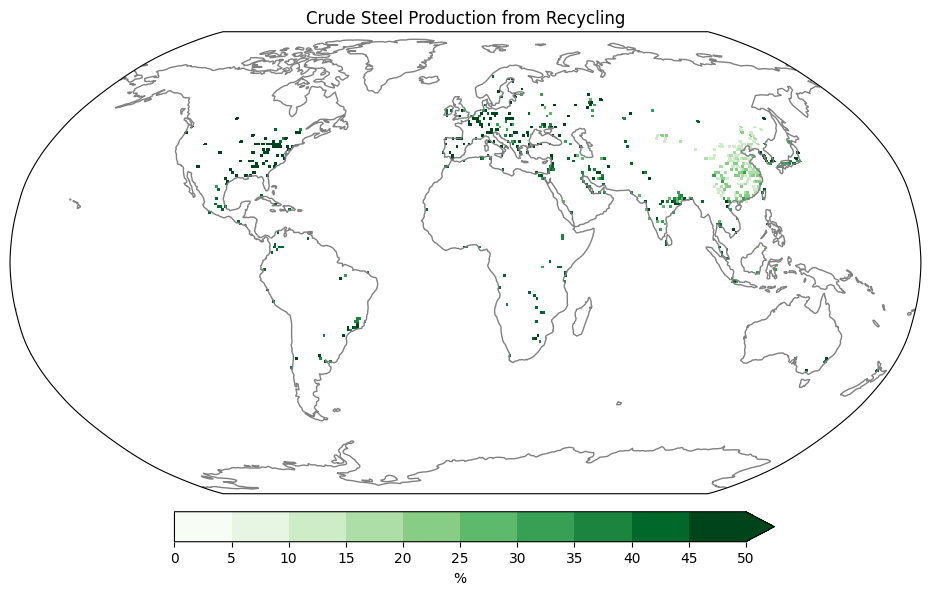

<GeoAxes: title={'center': 'Crude Steel Production from Recycling'}>

In [113]:
ssm.plot_map(ds_steel.mean(dim="time"), "%_recycling_steel", color="Greens", 
            vmin=0, vmax=50, extend_max=True, title="Crude Steel Production from Recycling", label="%",
            output_dir=plot_path, filename="crude_steel_from_scraps.pdf"
            )